# MT Data-conditioned VAE

CVAE/VAE code trained on Line 1 Central Region, with Line 3 as validation and Line 2 as test 1 (eventually - next step is to get test set(s) finalized and included in code)

In [1]:
# pip install tensorflow

In [2]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

In [3]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [4]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    # obs_xs = line[:,270:285]
    # print(obs_xs.shape)
    obs_zs = -line[:,286:301]
    print(obs_zs.shape)
    print(cond.shape)
    # obs_total = np.concatenate((obs_xs, obs_zs), axis=1)
    # print(obs_total.shape)
    pred_zs = line[:,348:363]
    return line,cond, obs_zs, pred_zs

In [5]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

# print(obs1)

(16258, 15)
(16258, 30)
(3355, 15)
(3355, 30)
(17419, 15)
(17419, 30)


In [6]:
line94, cond94, obs94, pred94 = import_file('Central_Line94.csv')
print(cond94)

(5748, 15)
(5748, 30)
[[0.027579 0.037342 0.067776 ... 0.001041 0.001032 0.001035]
 [0.029698 0.03982  0.070956 ... 0.001036 0.001028 0.00103 ]
 [0.030611 0.041253 0.073995 ... 0.001036 0.001028 0.00103 ]
 ...
 [0.015569 0.018243 0.027056 ... 0.000411 0.000421 0.000326]
 [0.016965 0.018962 0.025798 ... 0.000391 0.000406 0.000321]
 [0.016929 0.019097 0.025942 ... 0.000459 0.000483 0.00042 ]]


In [7]:
np.save('Line94_Central.npy', line94)
# np.save('Line94_Central_Conductivity.npy',cond94)
# np.save('Line94_Central_Observations.npy',obs94)

In [8]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])*1e-3
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [9]:
depth = np.append(0,depths)
# # print(depth)
# cond1_new = np.zeros((len(cond1[:,0]),32))
# for i in range(len(cond1[:,0])):
#     x = cond1[i]
#     y = depth
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [554,573]
#     x_new = f(y_new)
#     cond1_new[i] = np.append(x,x_new)
#     y = np.append(y_new,depths)
#     y.sort()

# cond2_new = np.zeros((len(cond2[:,0]),32))
# for i in range(len(cond2[:,0])):
#     x = cond2[i]
#     y = depth
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [554,573]
#     x_new = f(y_new)
#     cond2_new[i] = np.append(x,x_new)
#     y = np.append(y_new,depths)
#     y.sort()

# cond3_new = np.zeros((len(cond3[:,0]),32))
# for i in range(len(cond3[:,0])):
#     x = cond3[i]
#     y = depth
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [554,573]
#     x_new = f(y_new)
#     cond3_new[i] = np.append(x,x_new)
#     y = np.append(y_new,depths)
#     y.sort()
def format_models(file, depths):
    cond_new = np.zeros((len(file[:,0]),32))
    for i in range(len(file[:,0])):
        x = file[i]
        y = depths
        f = sp.interpolate.interp1d(y,x)
        y_new = [554,573]
        x_new = f(y_new)
        cond_new[i] = np.append(x,x_new)
    return cond_new

cond94_new = format_models(cond94,depth)

print(cond94_new)
print(len(depth))  
# print(len(cond1_new[0]))
# print(cond1_new[1])


[[0.027579   0.037342   0.067776   ... 0.001035   0.00103289 0.00103388]
 [0.029698   0.03982    0.070956   ... 0.00103    0.0010286  0.00102925]
 [0.030611   0.041253   0.073995   ... 0.00103    0.0010286  0.00102925]
 ...
 [0.015569   0.018243   0.027056   ... 0.000326   0.0003927  0.00036141]
 [0.016965   0.018962   0.025798   ... 0.000321   0.00038068 0.00035268]
 [0.016929   0.019097   0.025942   ... 0.00042    0.00046424 0.00044348]]
30


In [10]:
depths=np.append(depths,[554,573])
print(depths.shape)

np.save('Line94_Central_Conductivity.npy',cond94_new)

(31,)


In [11]:
# obs1_new = np.zeros((len(obs1[:,0]),16))
# for i in range(len(obs1[:,0])):
#     x = obs1[i]
#     y = times
#     # print(len(x), len(y))
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [16.054*1e-3]
#     x_new = f(y_new)
#     obs1_new[i] = np.append(x,x_new)
#     y = np.append(y_new,times)
#     y.sort()

# obs2_new = np.zeros((len(obs2[:,0]),16))
# for i in range(len(obs2[:,0])):
#     x = obs2[i]
#     y = times
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [16.054*1e-3]
#     x_new = f(y_new)
#     obs2_new[i] = np.append(x,x_new)
#     y = np.append(y_new,times)
#     y.sort()

# obs3_new = np.zeros((len(obs3[:,0]),16))
# for i in range(len(obs1[:,0])):
#     x = obs3[i]
#     y = times
#     # print(len(x), len(y))
#     f = sp.interpolate.interp1d(y,x)
#     y_new = [16.054*1e-3]
#     x_new = f(y_new)
#     obs3_new[i] = np.append(x,x_new)
#     y = np.append(y_new,times)
#     y.sort()


def format_raw(file,times):
    obs_new = np.zeros((len(file[:,0]),16))
    for i in range(len(file[:,0])):
        x = file[i]
        y = times
        f = sp.interpolate.interp1d(y,x)
        y_new = [16.054*1e-3]
        x_new = f(y_new)
        obs_new[i] = np.append(x,x_new)
    return obs_new
    
obs94_new = format_raw(obs94,times)

print(obs94_new)
print(len(times))

[[ 7.72649700e+00  6.95015100e+00  6.41803500e+00 ...  4.90700000e-02
   1.42310000e-02  1.42367169e-02]
 [ 7.69627400e+00  6.92732900e+00  6.39488900e+00 ...  5.03650000e-02
   1.46700000e-02  1.46758574e-02]
 [ 7.66496500e+00  6.90576600e+00  6.37250900e+00 ...  5.16500000e-02
   1.51030000e-02  1.51089972e-02]
 ...
 [ 7.75853300e+00  6.61903800e+00  5.83092900e+00 ...  4.49000000e-04
  -1.27400000e-03 -1.27371726e-03]
 [ 7.69706900e+00  6.53208500e+00  5.73442600e+00 ...  1.74400000e-03
  -4.39000000e-04 -4.38641779e-04]
 [ 7.62249300e+00  6.43346000e+00  5.62511300e+00 ...  3.08500000e-03
   3.43000000e-04  3.43449951e-04]]
15


In [12]:
times = np.append(times,16.054*1e-3)
times.sort()
print(len(times))

np.save('Line94_Central_Observations.npy',obs94_new)

16


In [13]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [14]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
                   data_std=0.1,
                   model_std=.01,
                   beta_vae=4,
                   model_loss_type='mae',
                   data_loss_type='mae'
                  )

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test_log = preprocess('Line2_Central_Conductivity.npy')
x_test_log94 = preprocess('Line94_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw = np.load('Line1_Central_Observations.npy')
x_validate_raw = np.load('Line3_Central_Observations.npy')
x_test_raw = np.load('Line2_Central_Observations.npy')
print(x_test_raw.shape)
x_test_raw94 = np.load('Line94_Central_Observations.npy')
print(x_test_raw94.shape)
#print(x_train_raw_log)

# x_train_raw = network.model_to_tanhs(x_train_raw_log)
# x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
# x_test1_raw = network.model_to_tanhs(x_test1_raw_log)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test = network.model_to_tanhs(x_test_log)
x_test94 = network.model_to_tanhs(x_test_log94)
# x_test2 = network.model_to_tanhs(x_test2_log)
# print(x_train)
# print(np.max(x_train))

AuEM_models1 = np.load('Line1_Central_Conductivity.npy')
AuEM_models2 = np.load('Line2_Central_Conductivity.npy')
AuEM_models3 = np.load('Line3_Central_Conductivity.npy')

(3355, 16)
(5748, 16)


In [16]:
x_train1 = x_train[0:3000,]
# print(x_train1)
x_validate1 = x_validate[0:3000,]
x_train_raw1 = x_train_raw[0:3000,]
x_validate_raw1 = x_validate_raw[0:3000,]
# x_test_raw1 = x_test_raw[0:1000,]
# print(x_train_raw1)
# plt.plot(x_train_raw1[0],np.append(0,depths))

In [17]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = x_train1[:,:,0]
# print(train_data)
# print("train data", train_data.shape)
# print('.........')


raw_train = np.asarray(x_train_raw1.T)
print(np.shape(raw_train[:,0]))
print(times)
raw_train_T = raw_train*1e-15
raw_train_data = np.gradient(raw_train_T,times, axis=0)
raw_train_data = -np.abs(raw_train_data).T
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data.shape)
print(raw_train_data[0])
raw_validate = np.asarray(x_validate_raw1.T)
raw_validate_T = raw_validate*1e-15
raw_validate_data = np.gradient(raw_validate_T,times, axis=0)
raw_validate_data = -np.abs(raw_validate_data).T
validate_data = x_validate1[:,:,0]
# raw_validate_data = -x_validate_raw1

raw_test = np.asarray(x_test_raw.T)
raw_test_T = raw_test*1e-15
print(raw_test_T.shape)
raw_test_data = np.gradient(raw_test_T,times, axis=0)
raw_test_data = -np.abs(raw_test_data).T

raw_test94 = np.asarray(x_test_raw94.T)
raw_test94_T = raw_test94*1e-15
print(raw_test94_T.shape)
raw_test_data94 = np.gradient(raw_test94_T,times, axis=0)
raw_test_data94 = -np.abs(raw_test_data94).T

# print(raw_validate_data)
# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

(16,)
[1.3000e-05 3.9000e-05 6.5000e-05 1.0400e-04 1.6900e-04 2.7300e-04
 4.4300e-04 7.0300e-04 1.0940e-03 1.6930e-03 2.6300e-03 4.1020e-03
 6.4060e-03 9.9610e-03 1.6054e-02 1.6055e-02]
raw_train_data (3000, 16)
[-3.56506538e-11 -2.61857885e-11 -1.42078564e-11 -9.22796026e-12
 -6.33067352e-12 -4.33213139e-12 -2.95920500e-12 -2.04432837e-12
 -1.40115052e-12 -9.33316057e-13 -5.82337001e-13 -3.35067112e-13
 -1.78962703e-13 -8.86255387e-14 -5.08564564e-14 -5.08731539e-14]
(16, 3355)
(16, 5748)


In [18]:
# plt.plot(train_data[0],np.append(0,depths))
# plt.plot(obs1_new[0], np.append(0,depths), color='red')

In [19]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [20]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')
print(train_data.shape)
print(raw_train_data.shape)

# plt.plot(x_train1[0],np.append(0,depths))
# plt.plot(train_data[0],np.append(0,depths))

(3000, 32)
(3000, 16)


In [21]:
# # Create batches and shuffle
BATCH_SIZE = 100

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_data, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(validate_data, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
# print(mean_model_value, rel_model_std)
print('data_std',rel_data_std)

data_std [0.23891686 0.21545129 0.17114653 0.11440777 0.06350552 0.03776945
 0.03950843 0.0518289  0.055912   0.04131562 0.01030593 0.0077598
 0.02791561 0.11101098 0.20474688 0.28933333 0.35932768 0.41436906
 0.45586558 0.48587526 0.5066571  0.52039859 0.52903996 0.53418895
 0.5370845  0.53861548 0.53937436 0.53972565 0.5398741  0.53991796
 0.53988716 0.53990161]


In [22]:
# plt.plot(train_dataset[0],np.append(0,depths))

In [23]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=0.01,
                   model_loss_type='mae',
                   data_loss_type='mae'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [24]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, 32))
# print('i_random_train',i_random_train)
# print('random_train',random_train)
print(network.predict_tanh(random_train))
# predict their data
# print(n_cells)
random_data = network.predict_tanh(random_train.reshape(16, 32, 1))
# print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
# print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
print('latent_input',latent_input)
# print('n_data',network.n_data)
random_data1 = random_data[:,:16]
data_input = tf.reshape(random_data1,(16,network.n_time))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

tf.Tensor(
[[-6.45190706e-11 -1.99556881e-11 -1.22700435e-11 -8.18726077e-12
  -5.61505443e-12 -3.98589885e-12 -2.82299423e-12 -1.95049424e-12
  -1.28353296e-12 -8.12762509e-13 -5.14624042e-13 -3.17465807e-13
  -1.73849243e-13 -8.02676136e-14 -2.78755290e-14 -2.78712498e-14]
 [-6.60474592e-11 -2.04724484e-11 -1.25295017e-11 -8.33827105e-12
  -5.71352601e-12 -4.05631995e-12 -2.87305704e-12 -1.98522752e-12
  -1.30706112e-12 -8.28317395e-13 -5.24601738e-13 -3.23317924e-13
  -1.76740648e-13 -8.14329818e-14 -2.82145929e-14 -2.82102527e-14]
 [-6.64891822e-11 -2.08589951e-11 -1.27632653e-11 -8.48190528e-12
  -5.80485616e-12 -4.12154989e-12 -2.92386449e-12 -2.02378088e-12
  -1.33274609e-12 -8.42648651e-13 -5.31862965e-13 -3.27474972e-13
  -1.79258043e-13 -8.27544210e-14 -2.87348745e-14 -2.87304631e-14]
 [-6.76867382e-11 -2.13858861e-11 -1.30504505e-11 -8.65207038e-12
  -5.91372307e-12 -4.19489053e-12 -2.97214814e-12 -2.05507464e-12
  -1.35354054e-12 -8.57583644e-13 -5.42685634e-13 -3.34058166e

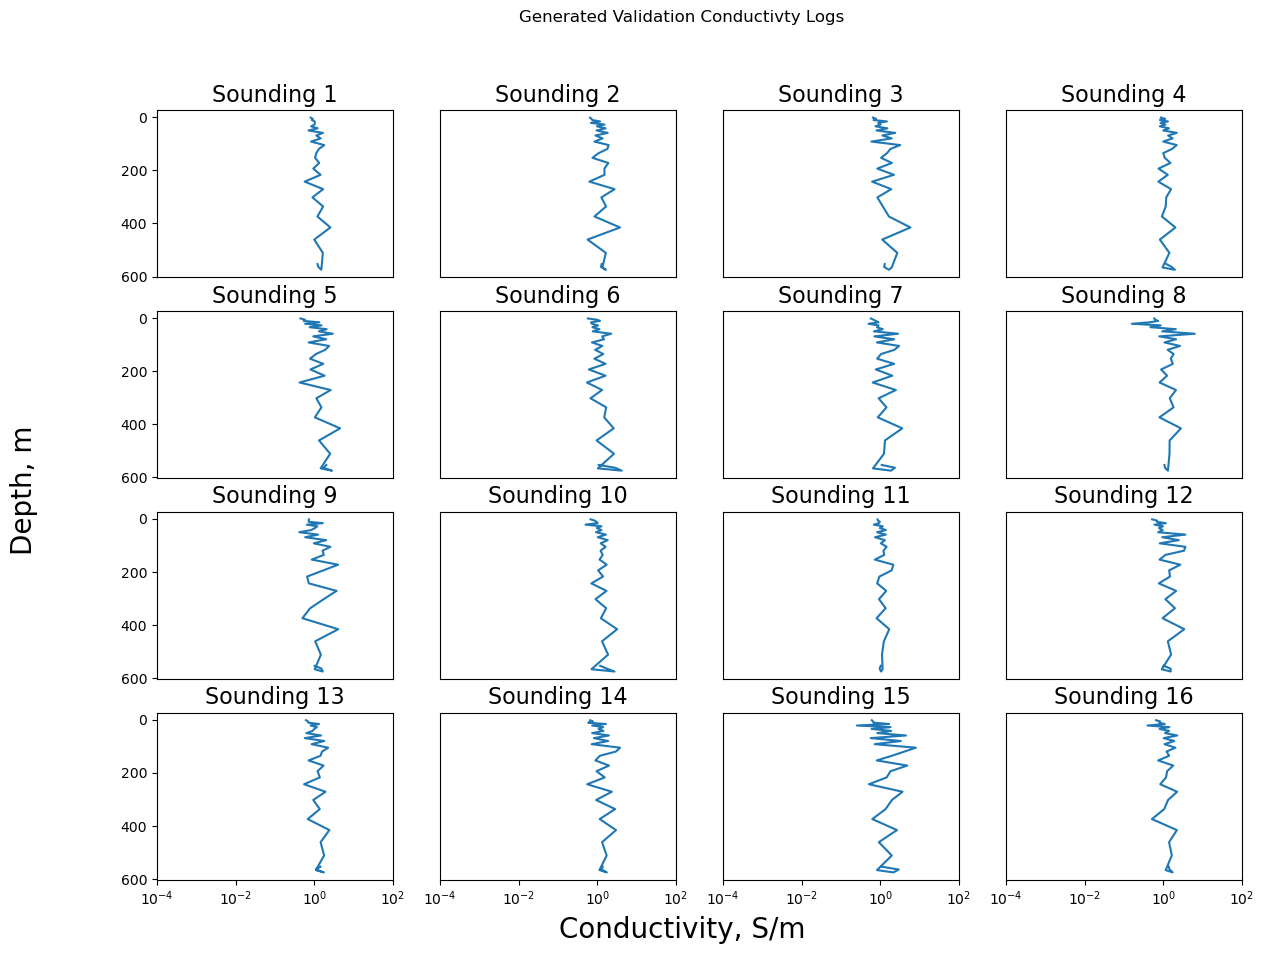

57428

<Figure size 640x480 with 0 Axes>

In [25]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.00005, 0.5)

# Train

In [27]:
epochs = 30

In [28]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(train_x)
        train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
        train_terms.append([tt.numpy() for tt in train_term])
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, train_term[0], train_term[1], train_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))


Epoch: 1, Data misfit: 1.374e-11, Reconstruction: 2.493e+03, KL: 0.00153, Elapsed 304.6 s
Epoch: 2, Data misfit: 1.553e-11, Reconstruction: 2.352e+03, KL: 0.001113, Elapsed 436.9 s
Epoch: 3, Data misfit: 2.104e-11, Reconstruction: 2.233e+03, KL: 0.0009446, Elapsed 509.7 s
Epoch: 4, Data misfit: 2.734e-11, Reconstruction: 2.114e+03, KL: 0.001749, Elapsed 542.2 s
Epoch: 5, Data misfit: 3.648e-11, Reconstruction: 1.981e+03, KL: 0.002098, Elapsed 533.7 s
Epoch: 6, Data misfit: 4.71e-11, Reconstruction: 1.835e+03, KL: 0.004584, Elapsed 815.7 s
Epoch: 7, Data misfit: 5.829e-11, Reconstruction: 1.646e+03, KL: 0.005886, Elapsed 469.6 s
Epoch: 8, Data misfit: 7.862e-11, Reconstruction: 1.381e+03, KL: 0.01485, Elapsed 478.0 s
Epoch: 9, Data misfit: 8.301e-11, Reconstruction: 1.15e+03, KL: 0.02301, Elapsed 473.6 s
Epoch: 10, Data misfit: 7.05e-11, Reconstruction: 969.5, KL: 0.03304, Elapsed 476.0 s
Epoch: 11, Data misfit: 5.439e-11, Reconstruction: 816.7, KL: 0.05593, Elapsed 469.6 s
Epoch: 12, D

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load networks

In [29]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [30]:
loss_terms = np.load(run+'/losses.npy')

In [31]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [32]:
plt.rcParams.update({'font.size': 18})

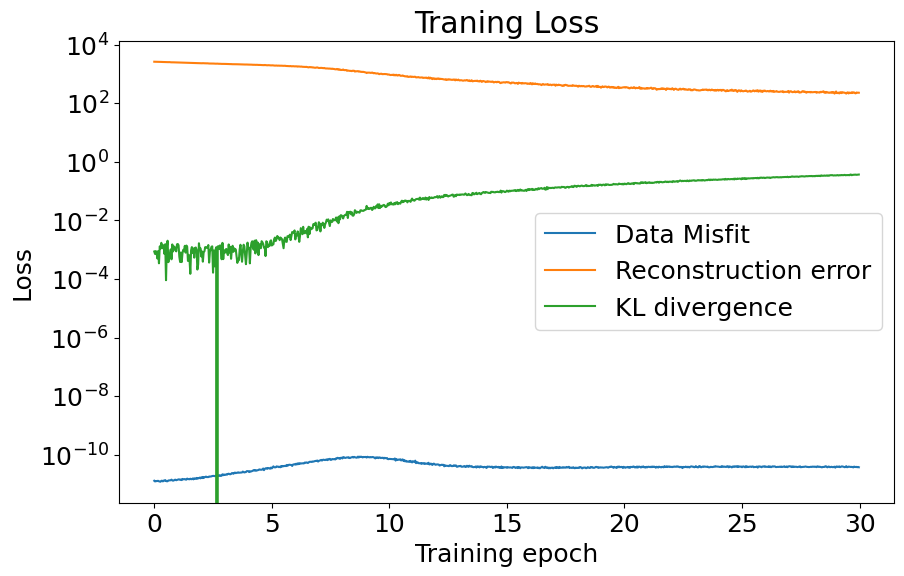

In [33]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data Misfit','Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

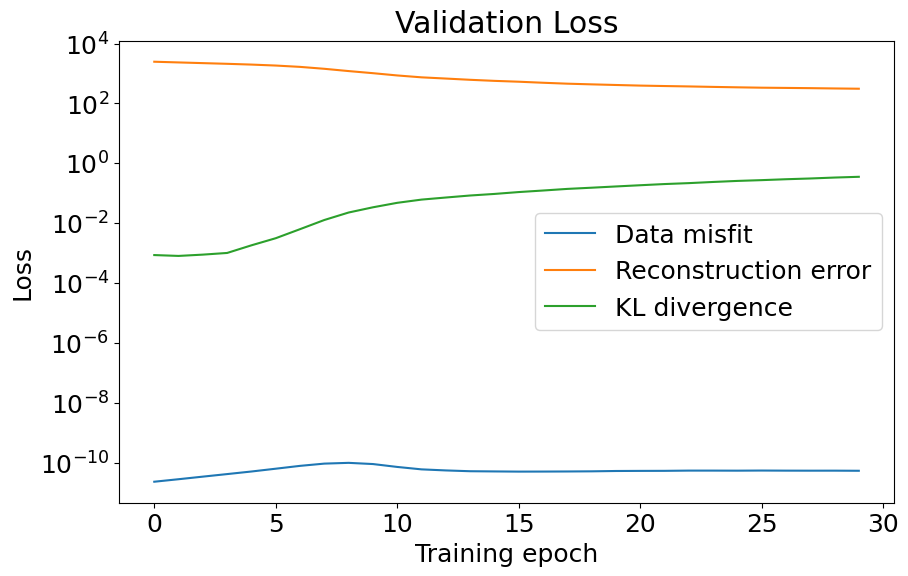

In [34]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

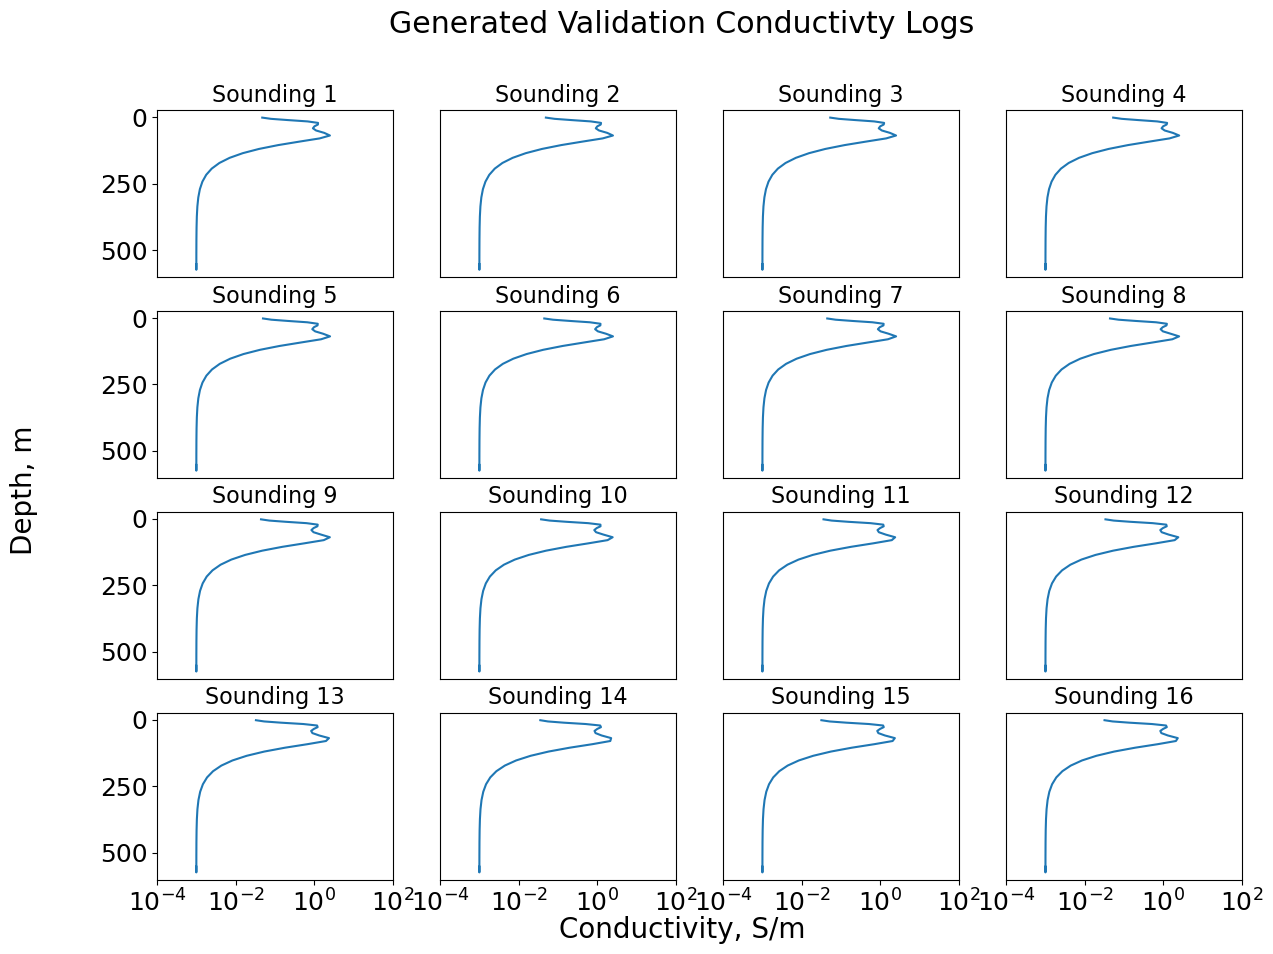

In [35]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=False)

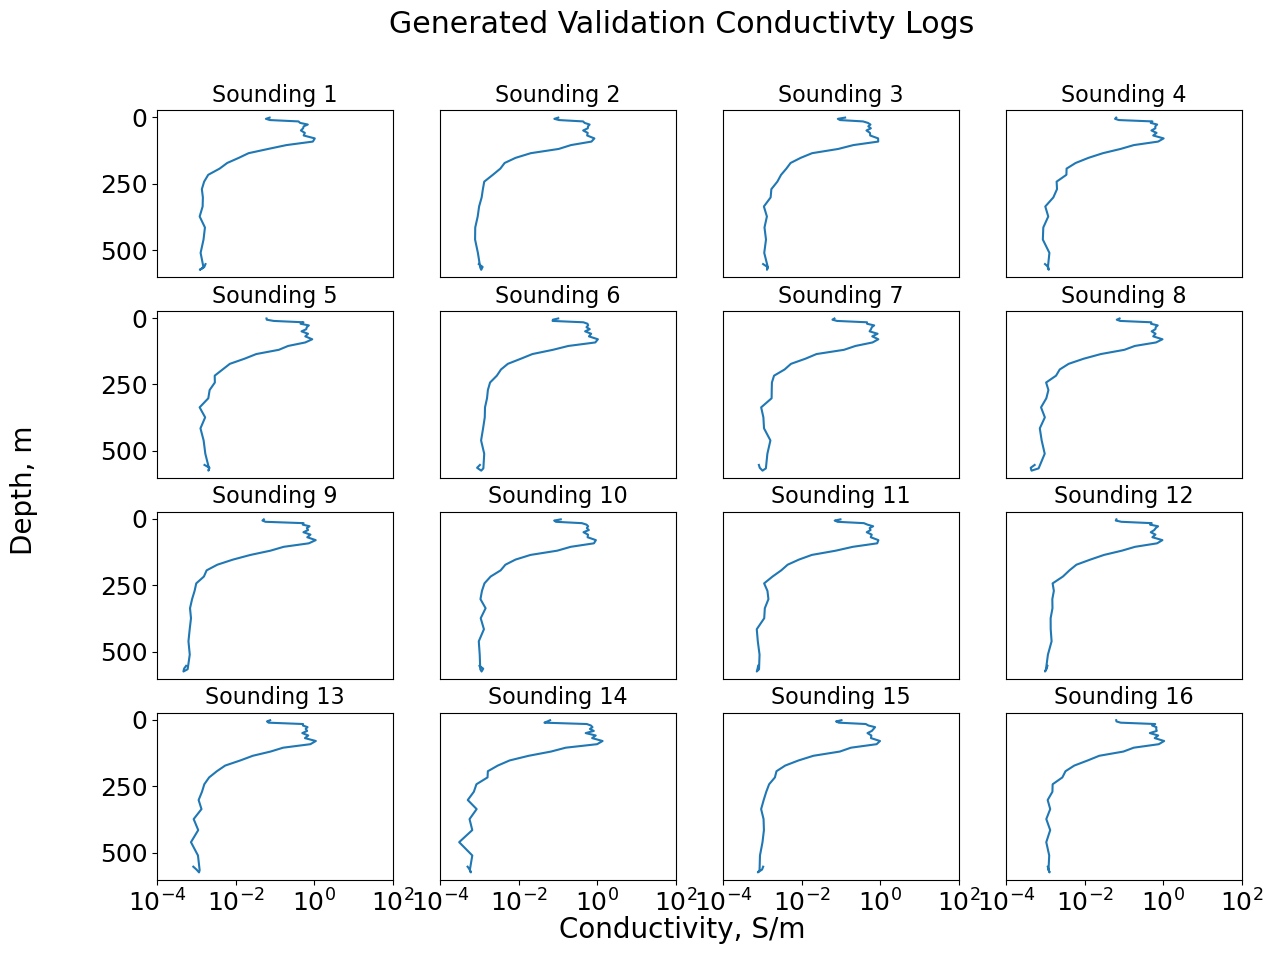

In [36]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
network.plot_models(latent=zmd)

In [37]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

zmd_tanhs = network.decode(zmd, apply_tanh=True)
zmd_samples = zmd_tanhs.shape[0]
zmd_tanhs = np.reshape(zmd_tanhs, (zmd_samples, network.n_model))
zmd_logs = np.exp(network.tanhs_to_model(zmd_tanhs))
zmdlogs = zmd_logs-0.5

true_validate = np.exp(network.tanhs_to_model(x_validate[0:16]))

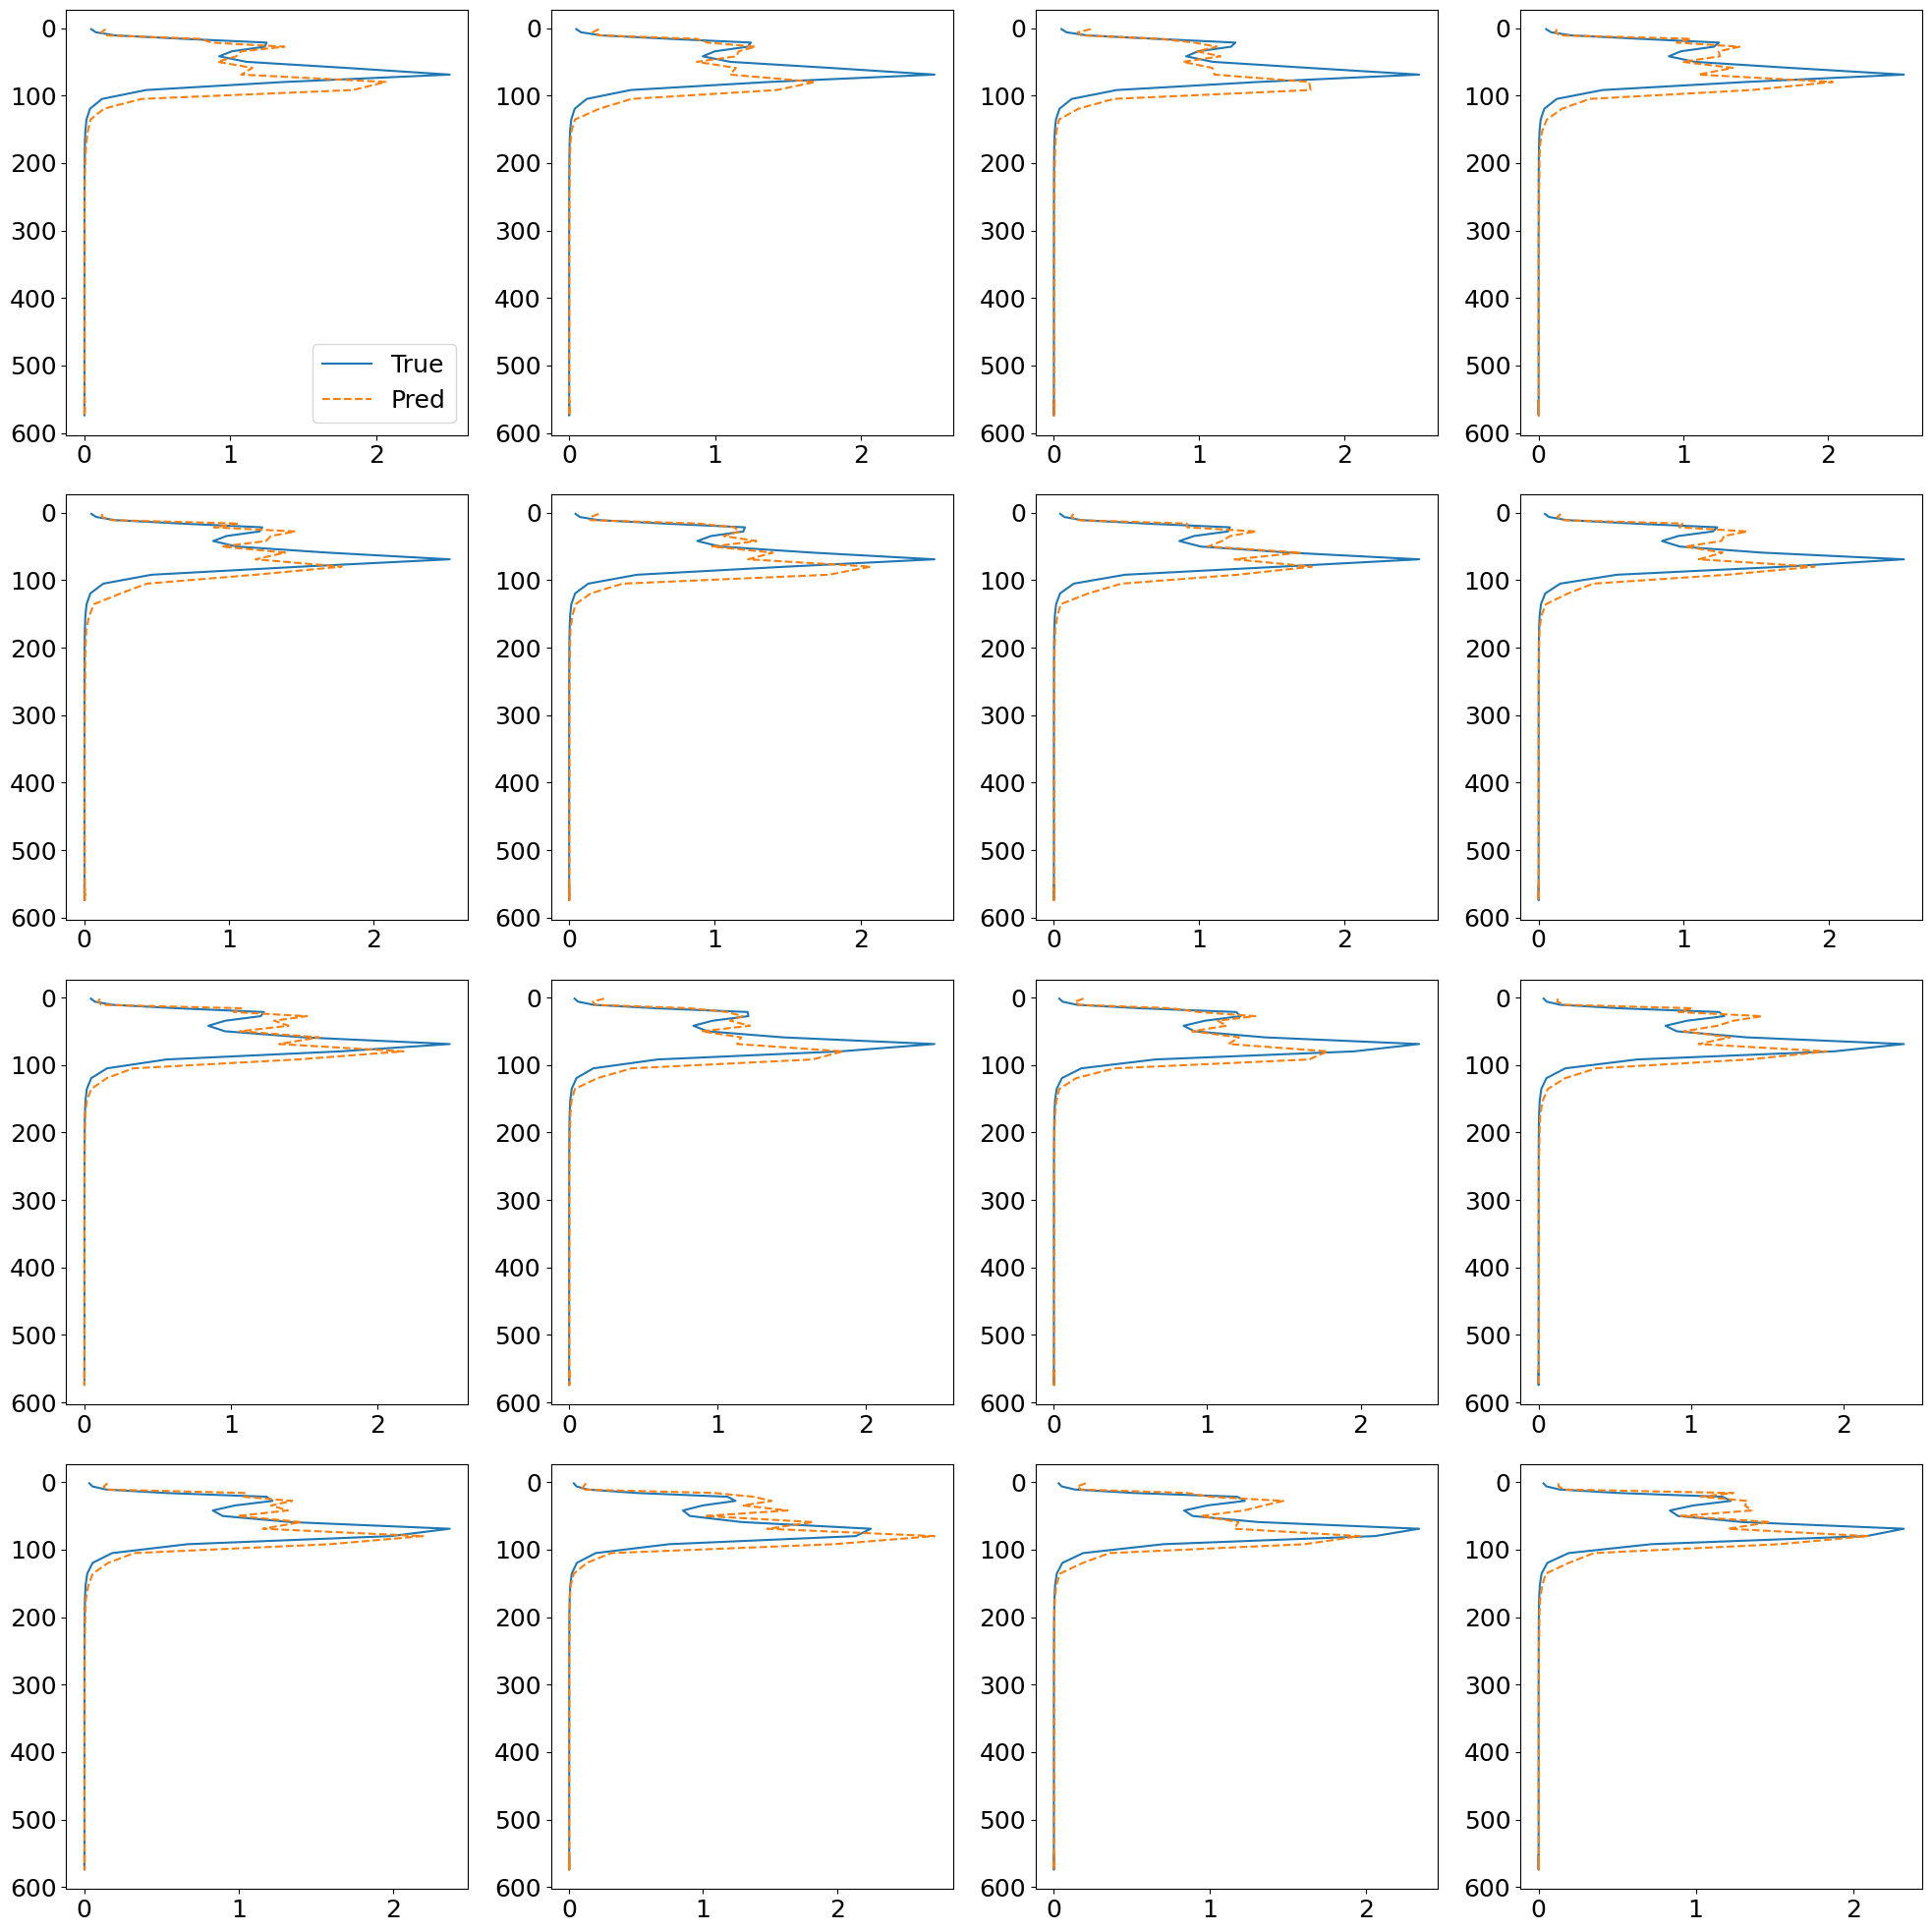

In [38]:
#Why does x2 on the predicted make it match better???
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_validate[i], plot_depths, label='True')
    plt.plot(zmd_logs[i]*2, plot_depths, label='Pred', linestyle='--')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

In [39]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [40]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)
print(tanhs)

tf.Tensor(
[[[-0.20433491]
  [-0.22147495]
  [-0.20291993]
  [-0.07207078]
  [-0.06483139]
  [-0.02948299]
  [-0.04848422]
  [-0.05102237]
  [-0.06119275]
  [-0.04306643]
  [-0.04840859]
  [ 0.00254282]
  [-0.0063826 ]
  [-0.12729838]
  [-0.21086931]
  [-0.30065733]
  [-0.34534305]
  [-0.39845258]
  [-0.43327945]
  [-0.4855003 ]
  [-0.5041464 ]
  [-0.51464635]
  [-0.5099315 ]
  [-0.5110059 ]
  [-0.524641  ]
  [-0.50049233]
  [-0.5069965 ]
  [-0.5203461 ]
  [-0.50706047]
  [-0.5240229 ]
  [-0.50350237]
  [-0.49798396]]

 [[-0.178646  ]
  [-0.19671412]
  [-0.17500697]
  [-0.06494662]
  [-0.05818888]
  [-0.03512424]
  [-0.04240566]
  [-0.04358029]
  [-0.06461071]
  [-0.04377085]
  [-0.04645003]
  [-0.01331989]
  [-0.02657335]
  [-0.12046477]
  [-0.17664099]
  [-0.30445918]
  [-0.37411043]
  [-0.42423064]
  [-0.44380817]
  [-0.4781873 ]
  [-0.5176421 ]
  [-0.5238305 ]
  [-0.529503  ]
  [-0.54119605]
  [-0.5475768 ]
  [-0.5588764 ]
  [-0.5595866 ]
  [-0.5467329 ]
  [-0.5359845 ]
  [-0.53149

In [41]:
minmax(x_test[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.5399266299885006>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.03254183984457575>)

(16, 36)


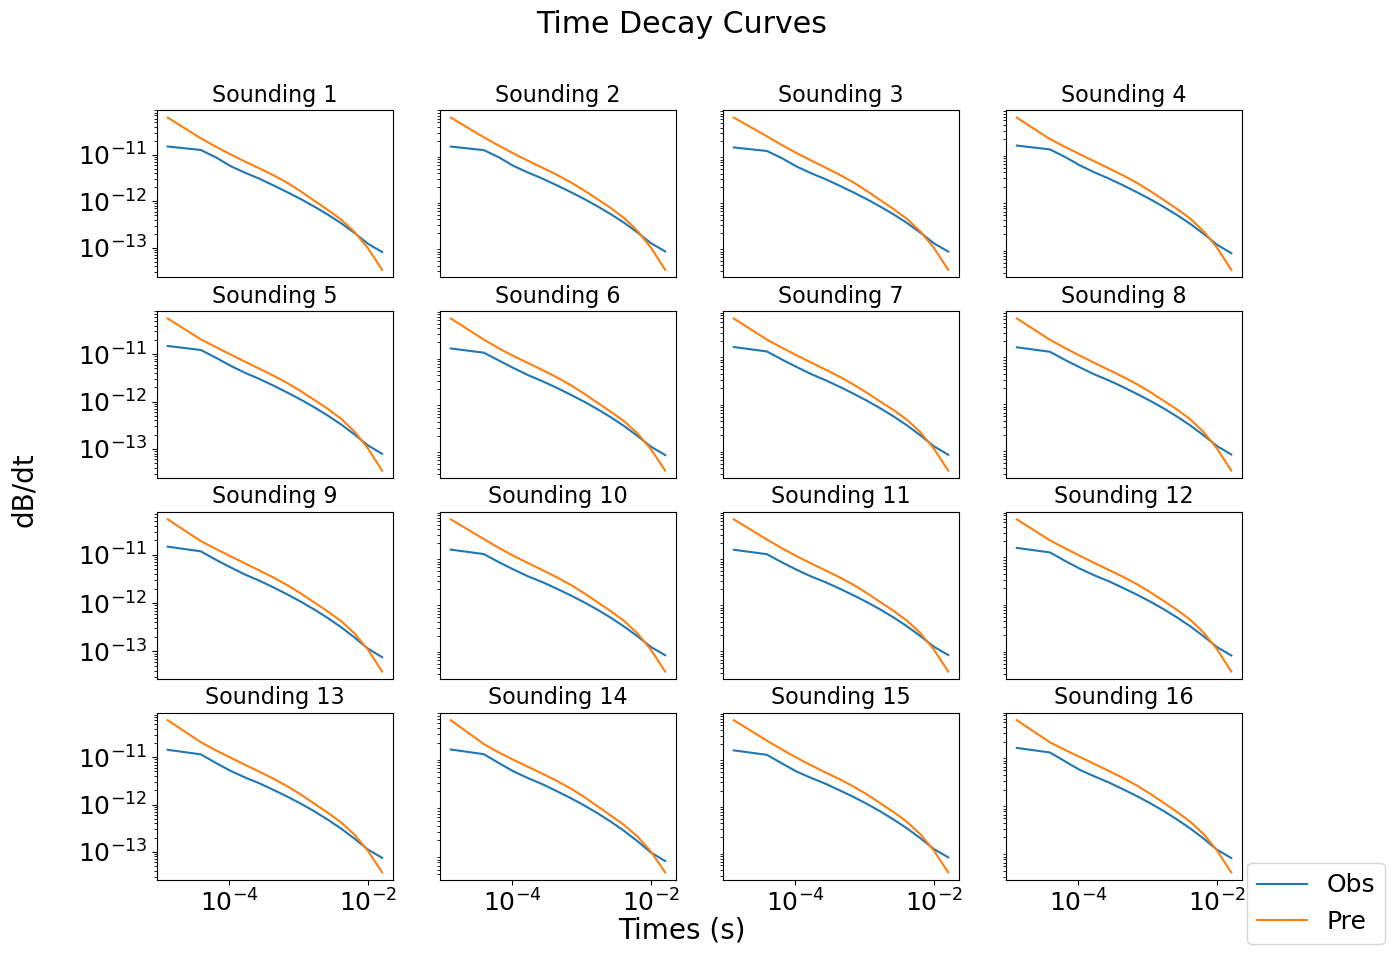

In [42]:
print(zmd.shape)
network.plot_data(latent=zmd)

# d_obs is from validation seta

d_obs: (16, 16)
d_pre: (16, 16)
data_std: (1, 32, 1)
n_time: 16
d_std: (1, 16)
data tf.Tensor(
[[-4.77454326e-11 -9.87570442e-12 -6.02161637e-12 -4.47884655e-12
  -3.02264550e-12 -2.03614989e-12 -1.41129881e-12 -9.08475769e-13
  -5.09630424e-13 -2.59942892e-13 -1.37359362e-13 -6.69424639e-14
  -1.08602363e-14 -2.35446970e-14 -4.76999523e-14 -4.77319803e-14]
 [-4.81564580e-11 -1.11978612e-11 -6.76035703e-12 -4.91261502e-12
  -3.28135522e-12 -2.16367115e-12 -1.48073914e-12 -9.71898235e-13
  -5.78178130e-13 -3.25548182e-13 -1.84057197e-13 -8.89450189e-14
  -1.66857630e-14 -2.37545782e-14 -4.84559360e-14 -4.84876760e-14]
 [-5.11297081e-11 -1.34661943e-11 -7.89472741e-12 -5.47495296e-12
  -3.65048313e-12 -2.38260713e-12 -1.57280460e-12 -9.88446846e-13
  -5.54786143e-13 -2.90544336e-13 -1.57362296e-13 -7.56480111e-14
  -1.23348326e-14 -2.44760267e-14 -4.79835660e-14 -4.80150350e-14]
 [-4.27228045e-11 -7.99214601e-12 -5.32088349e-12 -4.06618099e-12
  -2.86642802e-12 -1.92839624e-12 -1.3258907

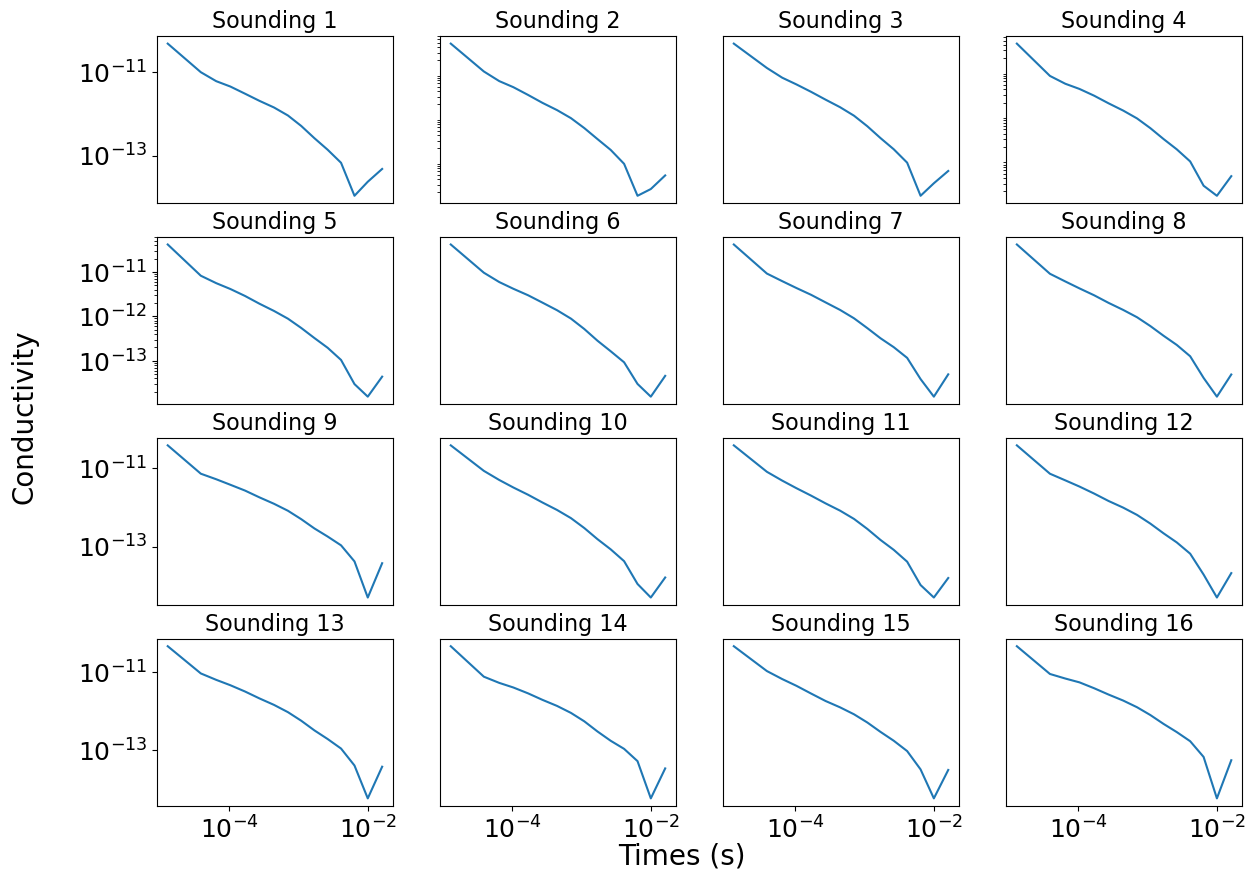

In [43]:
network.plot_residuals(latent=zmd, weighted=False)

# Randomize latent; does data still fit?

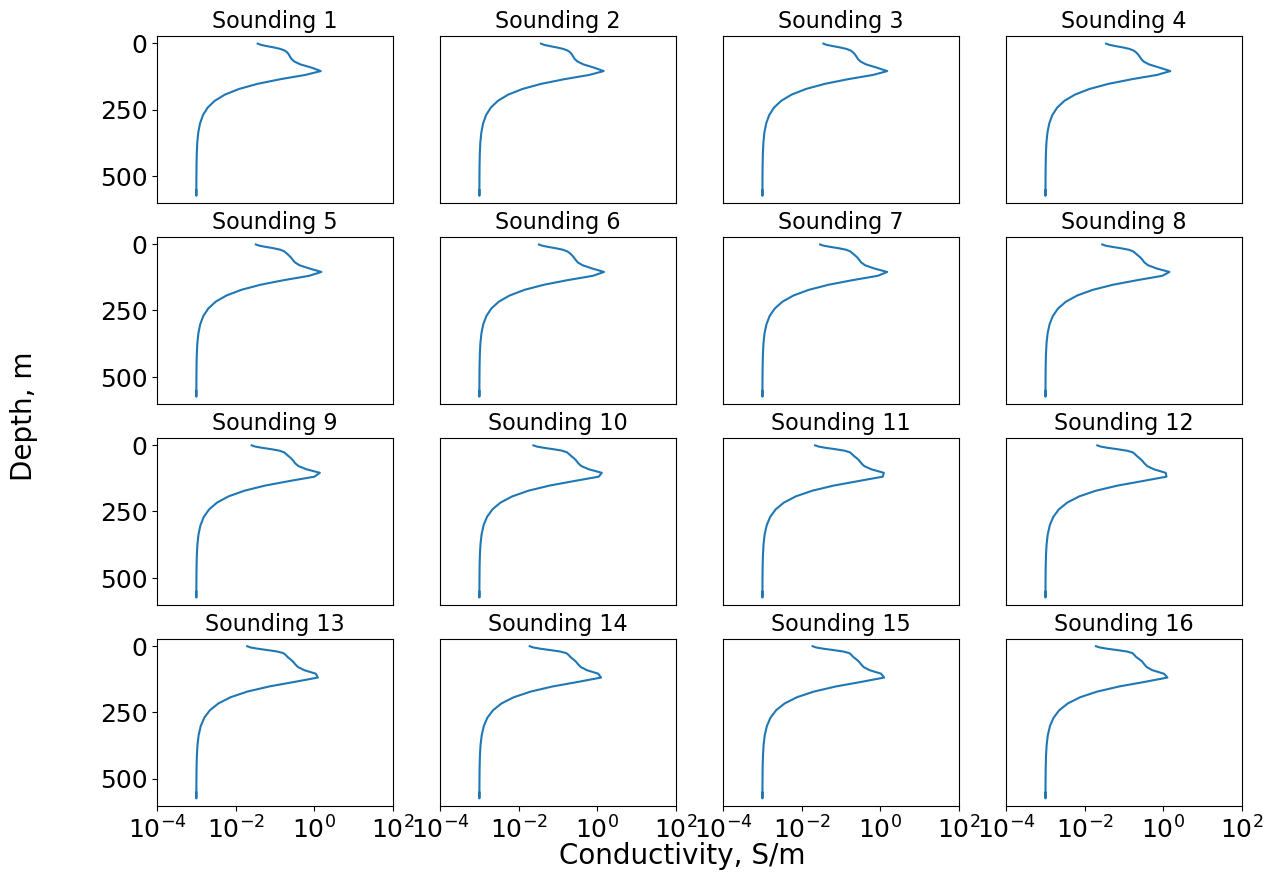

In [44]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test[0   :16])), depths=depths)

In [45]:
print(x_test[0:1].shape)

(1, 32, 1)


In [46]:
data0 = tf.tile(z_data[0:1],[16,1])
# print(latent_input)
data0 = tf.cast(data0, tf.float32)
# print(data0)
zmd2 = tf.concat((latent_input,data0),-1)
# print(zmd2)

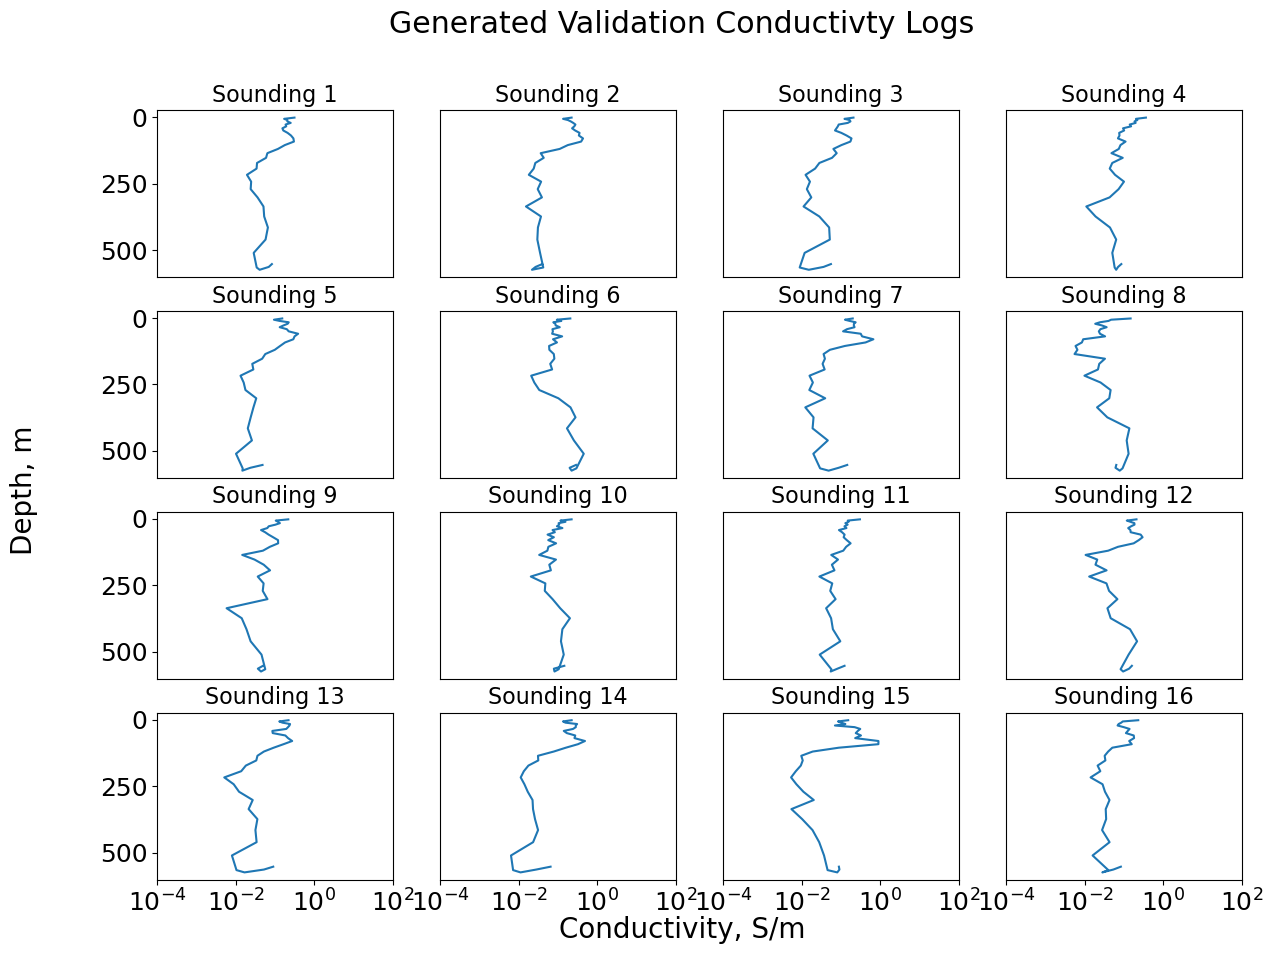

In [47]:
network.plot_models(latent=zmd2)

In [48]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))
zmd2 = zmd2_logs-0.5

true_test = np.exp(network.tanhs_to_model(x_test[0   :16]))
print(zmd2_tanhs)

[[-0.09054384 -0.13802524 -0.12324332 -0.12316585 -0.1077607  -0.13137212
  -0.12818149 -0.14582741 -0.14174101 -0.12206039 -0.10645565 -0.09541927
  -0.09303126 -0.13470002 -0.16628717 -0.21457934 -0.22072461 -0.2619351
  -0.26408637 -0.3080812  -0.2889043  -0.29110825 -0.2596381  -0.23244667
  -0.2292407  -0.21219303 -0.22298533 -0.27726358 -0.26349935 -0.2499924
  -0.20834218 -0.1939319 ]
 [-0.11766899 -0.15685499 -0.13426143 -0.12147295 -0.11012316 -0.10012355
  -0.10519019 -0.11548807 -0.10142118 -0.08123998 -0.08435096 -0.0653187
  -0.07397372 -0.1349388  -0.17225124 -0.25909227 -0.24521035 -0.28377622
  -0.29109296 -0.31357318 -0.25719908 -0.27279505 -0.25349635 -0.32658917
  -0.2578061  -0.2718002  -0.27452904 -0.26201352 -0.2473387  -0.29922035
  -0.28267524 -0.25215936]
 [-0.12294065 -0.16427681 -0.14043772 -0.13664837 -0.14898556 -0.19059066
  -0.19453168 -0.20063527 -0.2076315  -0.17864972 -0.15458982 -0.13203181
  -0.13704461 -0.17808907 -0.21504429 -0.19980083 -0.22115308

In [49]:
zmd2_logs.shape

(16, 32)

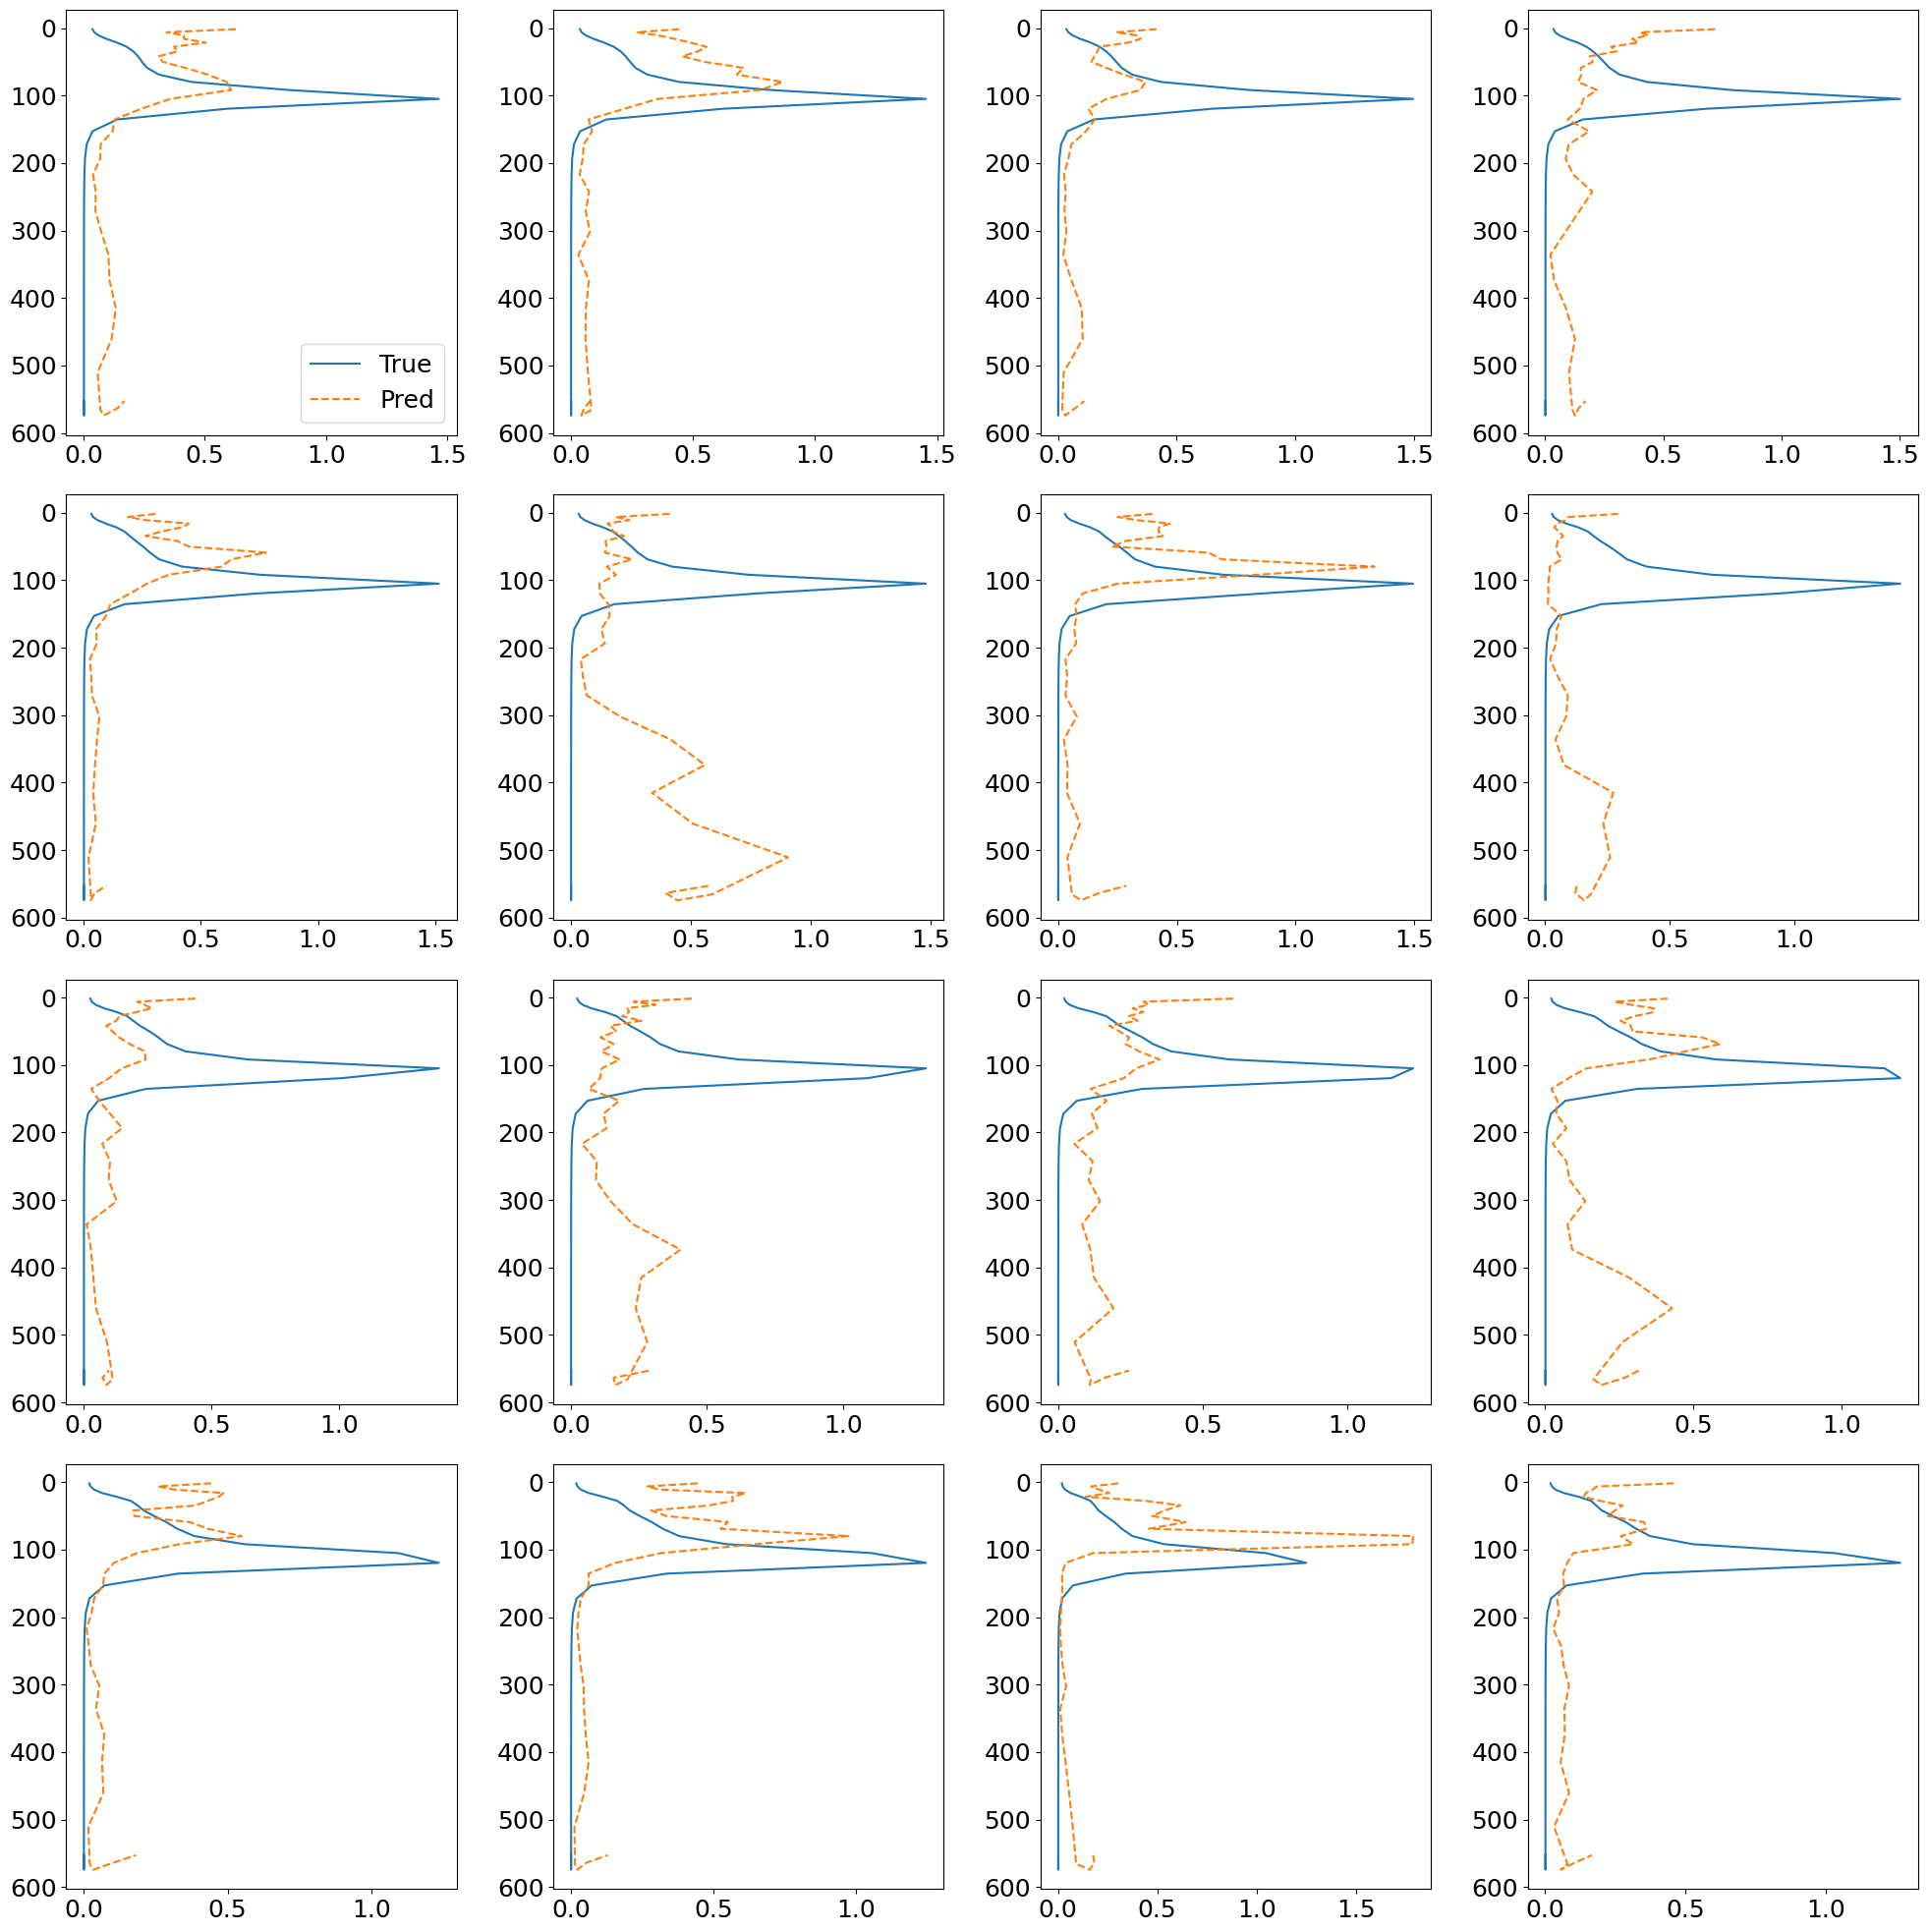

In [50]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_test[i], plot_depths, label='True')
    plt.plot(zmd2_logs[i]*2, plot_depths, label='Pred', linestyle='--')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
mean_true_cond = np.mean((AuEM_models3[0:1000,]), axis=0)
std_cond = np.std((zmd2_logs),axis=0)
uncertainty = np.mean(mean_cond+std_cond**2)
print(mean_true_cond)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

[1.37740863e-01 2.26505195e-01 4.55778963e-01 8.07430753e-01
 1.00856274e+00 9.94841990e-01 9.36682745e-01 9.11594407e-01
 1.04726203e+00 1.55475830e+00 2.14633486e+00 1.81433976e+00
 8.44755390e-01 2.55103990e-01 6.97993755e-02 2.25974128e-02
 9.17094101e-03 4.59369569e-03 2.75325020e-03 1.91037461e-03
 1.48666267e-03 1.26095100e-03 1.13756621e-03 1.07020001e-03
 1.03427990e-03 1.01590616e-03 1.00701110e-03 1.00298792e-03
 1.00135187e-03 1.00095534e-03 1.00123376e-03 1.00110314e-03]


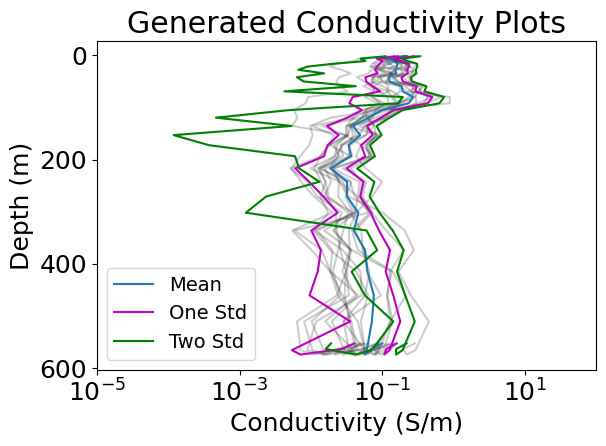

In [52]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond),plot_depths, c='m', label="One Std")
ax.semilogx(np.abs(mean_cond-std_cond), plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()



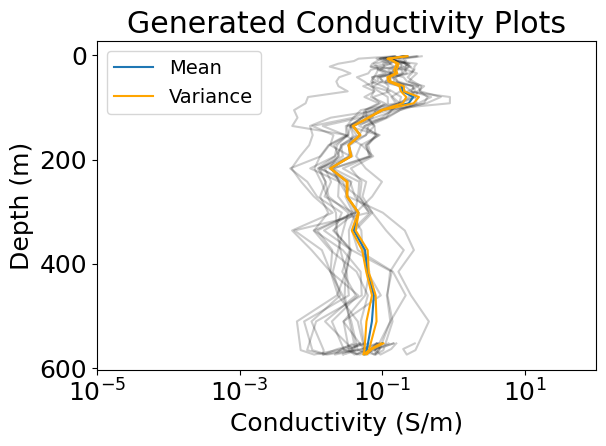

In [53]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(np.abs(mean_cond+std_cond**2), plot_depths, c='orange', label='Variance')
ax.semilogx(np.abs(mean_cond-std_cond**2), plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(1e-5, 1e2)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

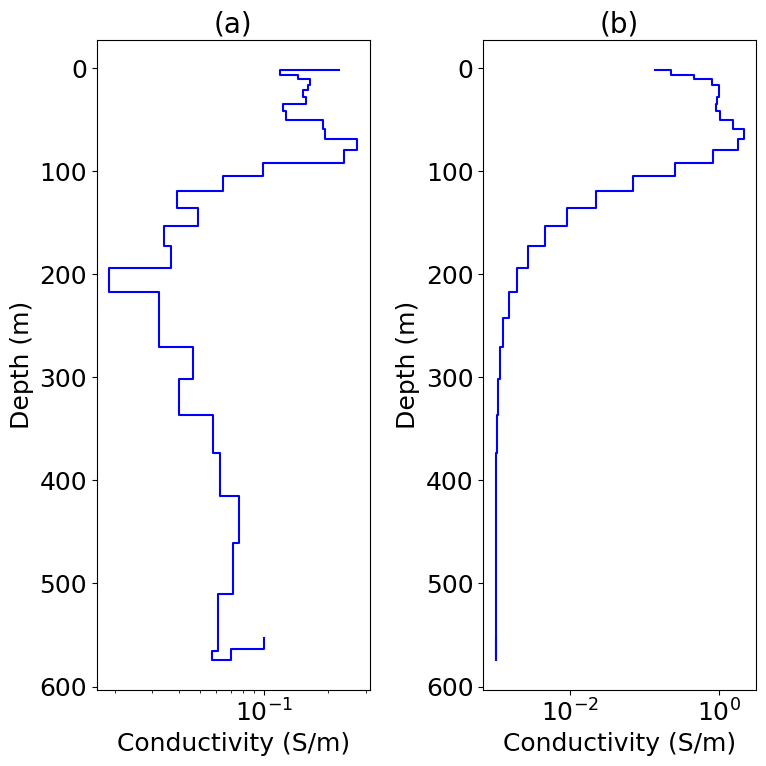

In [54]:
# # Example inputs
# conductivities = [0.01, 0.1, 0.05, 0.2, 0.01]  # Conductivity (S/m) for each layer
# thicknesses = [10, 20, 20, 30, 20]  # Thickness of each layer (m)

# # Compute depths from thicknesses
# depths = np.cumsum(thicknesses)  # Compute layer boundaries
# depths = np.insert(depths, 0, 0)  # Insert surface depth at 0

# # Create step-like depth and conductivity arrays
# depth_plot = np.repeat(plot_depths, 2)  # Duplicate depths for step changes
# conductivity_plot = np.repeat(zmd2_logs[0], 2)  # Duplicate conductivity values

depth_plot = np.repeat(plot_depths, 2)
# depth_plot=np.flip(depth_plot)

fig, ax = plt.subplots(1,2,figsize=(8, 8))

# plt.ticklabel_format(axis='y', style='sci', scilimits=(4, 4))
# fig.suptitle('VAE Generated Models')
for log in zmd2_logs:
    conductivity_plot = np.repeat(log,2)
    # ax[0].semilogx(conductivity_plot, depth_plot, drawstyle='steps-post', color='k', alpha=0.2)

# for i in AuEM_models3[0:1000,]:
    # ax[1].semilogx(i, plot_depths, drawstyle='steps-post', color='k', alpha=0.2)

mean_cond_plot = np.repeat(mean_cond,2)
mean_true_cond_plot = np.repeat(mean_true_cond,2)
ax[0].semilogx(mean_cond_plot, depth_plot, drawstyle='steps-post', c='b', label='Mean')
# ax.plot(mean_true_cond_plot, depth_plot, drawstyle='steps-post', c='r', label='True Mean')
ax[0].invert_yaxis()
# ax[0].invert_xaxis()
# Labels and title
ax[0].set_xscale('log')
ax[0].set_xlabel('Conductivity (S/m)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('(a)', fontsize=20)
# ax[0].legend()
ax[1].semilogx(mean_true_cond_plot, depth_plot, drawstyle='steps-post', c='b', label='Mean')
ax[1].invert_yaxis()
# Labels and title
# ax[1].set_xscale('log')
ax[1].set_xlabel('Conductivity (S/m)')
ax[1].set_ylabel('Depth (m)')
ax[1].set_title('(b)', fontsize=20)
# plt.grid()
plt.tight_layout()
plt.savefig('Comparison_GeneratedvsTrue.jpg')
plt.show()


In [55]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [56]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

In [57]:
# network.plot_residuals(latent=zmd2, weighted=True)

In [58]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [59]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [60]:
network.data_weights

array([[[  4.18555635],
        [  4.64142033],
        [  5.84294641],
        [  8.74066528],
        [ 15.74666158],
        [ 26.47642253],
        [ 25.3110522 ],
        [ 19.2942529 ],
        [ 17.88524949],
        [ 24.20392363],
        [ 97.0315347 ],
        [128.86931275],
        [ 35.82224528],
        [  9.00811805],
        [  4.88407919],
        [  3.45622125],
        [  2.78297515],
        [  2.41330761],
        [  2.1936291 ],
        [  2.05814141],
        [  1.97372148],
        [  1.92160399],
        [  1.89021639],
        [  1.87199681],
        [  1.86190441],
        [  1.85661206],
        [  1.85399987],
        [  1.85279316],
        [  1.85228372],
        [  1.85213325],
        [  1.85223891],
        [  1.85218934]]])

# Sample latent & different data soundings

In [61]:
# Plot true models for comparisons - need models for line 94 and adjust plot_logs to show true models too

data_batch = raw_test_data94[0:16]
latent_dim = 20  # known from model
latent_input = tf.random.normal((16, latent_dim))

In [62]:
zmd3 = tf.concat((latent_input, data_batch), -1)
print(zmd3.shape)

(16, 36)


In [63]:
zmd3_tanhs = network.decode(zmd3, apply_tanh=True)
zmd3_samples = zmd3_tanhs.shape[0]
zmd3_tanhs = np.reshape(zmd3_tanhs, (zmd3_samples, network.n_model))
zmd3_logs = np.exp(network.tanhs_to_model(zmd3_tanhs))
# zmd3 = 10**zmd3_logs

In [64]:
true_models = x_test94[0:16]
true_logs = np.exp(network.tanhs_to_model(true_models))
print(true_logs)

[[[0.027579  ]
  [0.037342  ]
  [0.067776  ]
  [0.146918  ]
  [0.251119  ]
  [0.229682  ]
  [0.14683   ]
  [0.088529  ]
  [0.057504  ]
  [0.042529  ]
  [0.037071  ]
  [0.039304  ]
  [0.051884  ]
  [0.081916  ]
  [0.119985  ]
  [0.10514   ]
  [0.053187  ]
  [0.021801  ]
  [0.009363  ]
  [0.00468   ]
  [0.002776  ]
  [0.001918  ]
  [0.001498  ]
  [0.001279  ]
  [0.001162  ]
  [0.001097  ]
  [0.001061  ]
  [0.001041  ]
  [0.001032  ]
  [0.001035  ]
  [0.00103289]
  [0.00103388]]

 [[0.029698  ]
  [0.03982   ]
  [0.070956  ]
  [0.149919  ]
  [0.248876  ]
  [0.2255    ]
  [0.145899  ]
  [0.08963   ]
  [0.05924   ]
  [0.044361  ]
  [0.038878  ]
  [0.041084  ]
  [0.053556  ]
  [0.083058  ]
  [0.119278  ]
  [0.101671  ]
  [0.050365  ]
  [0.020533  ]
  [0.008863  ]
  [0.004471  ]
  [0.002678  ]
  [0.001867  ]
  [0.001469  ]
  [0.001261  ]
  [0.001149  ]
  [0.001088  ]
  [0.001055  ]
  [0.001036  ]
  [0.001028  ]
  [0.00103   ]
  [0.0010286 ]
  [0.00102925]]

 [[0.030611  ]
  [0.041253  ]
  [0.0

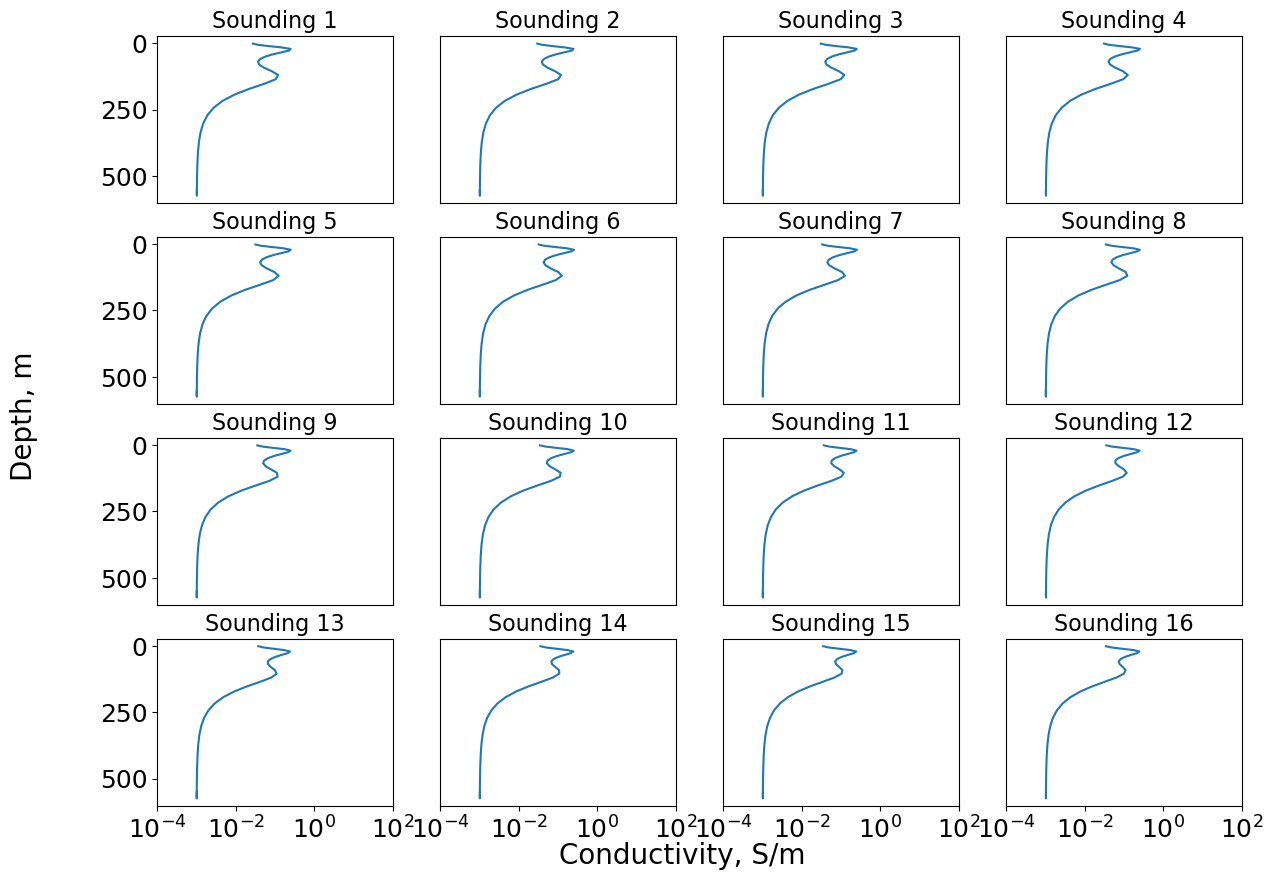

In [65]:
vae.plot_logs(true_logs, depths=depths)

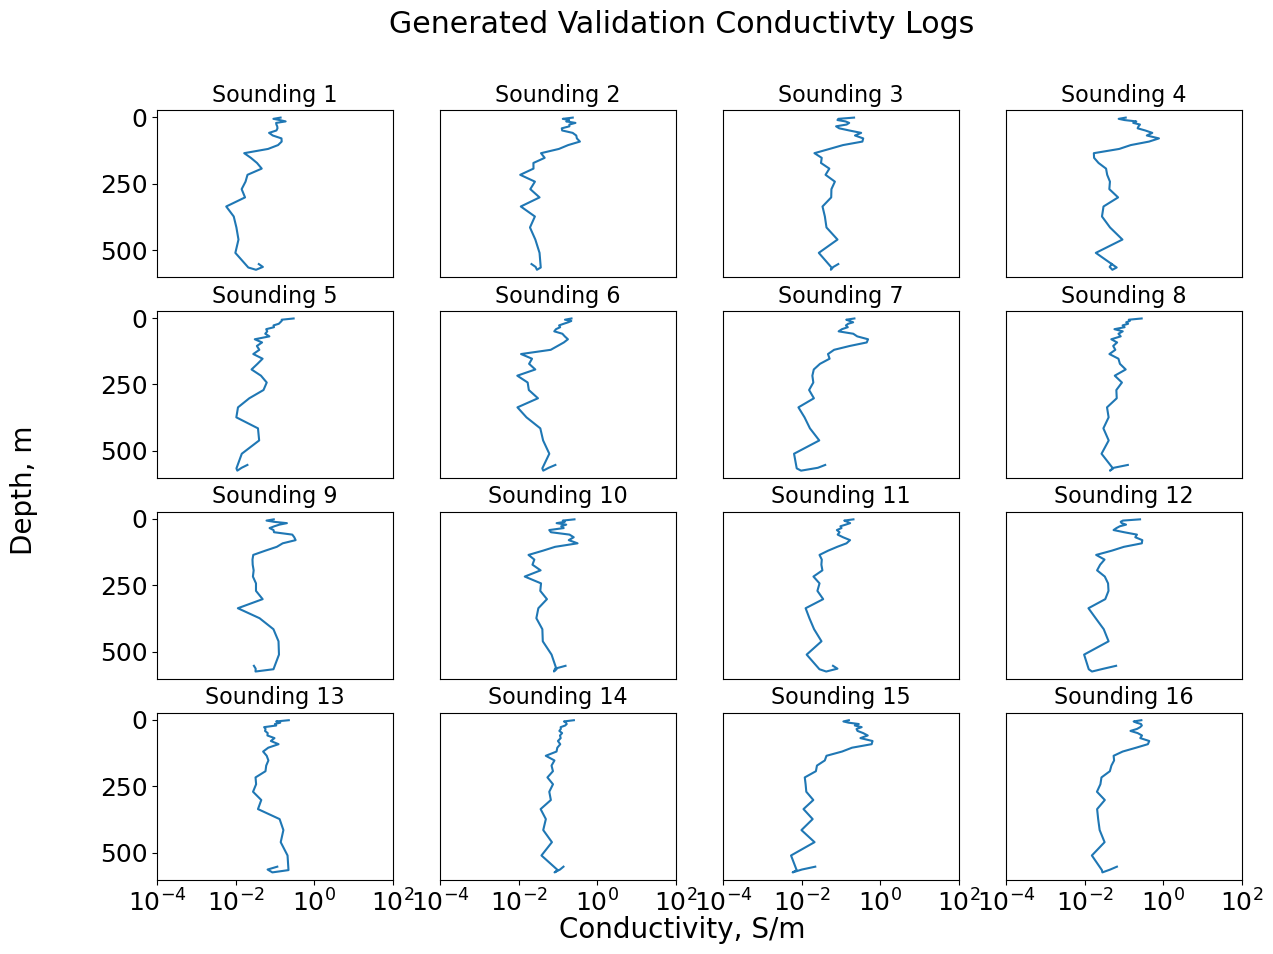

In [66]:
network.plot_models(latent=zmd3)

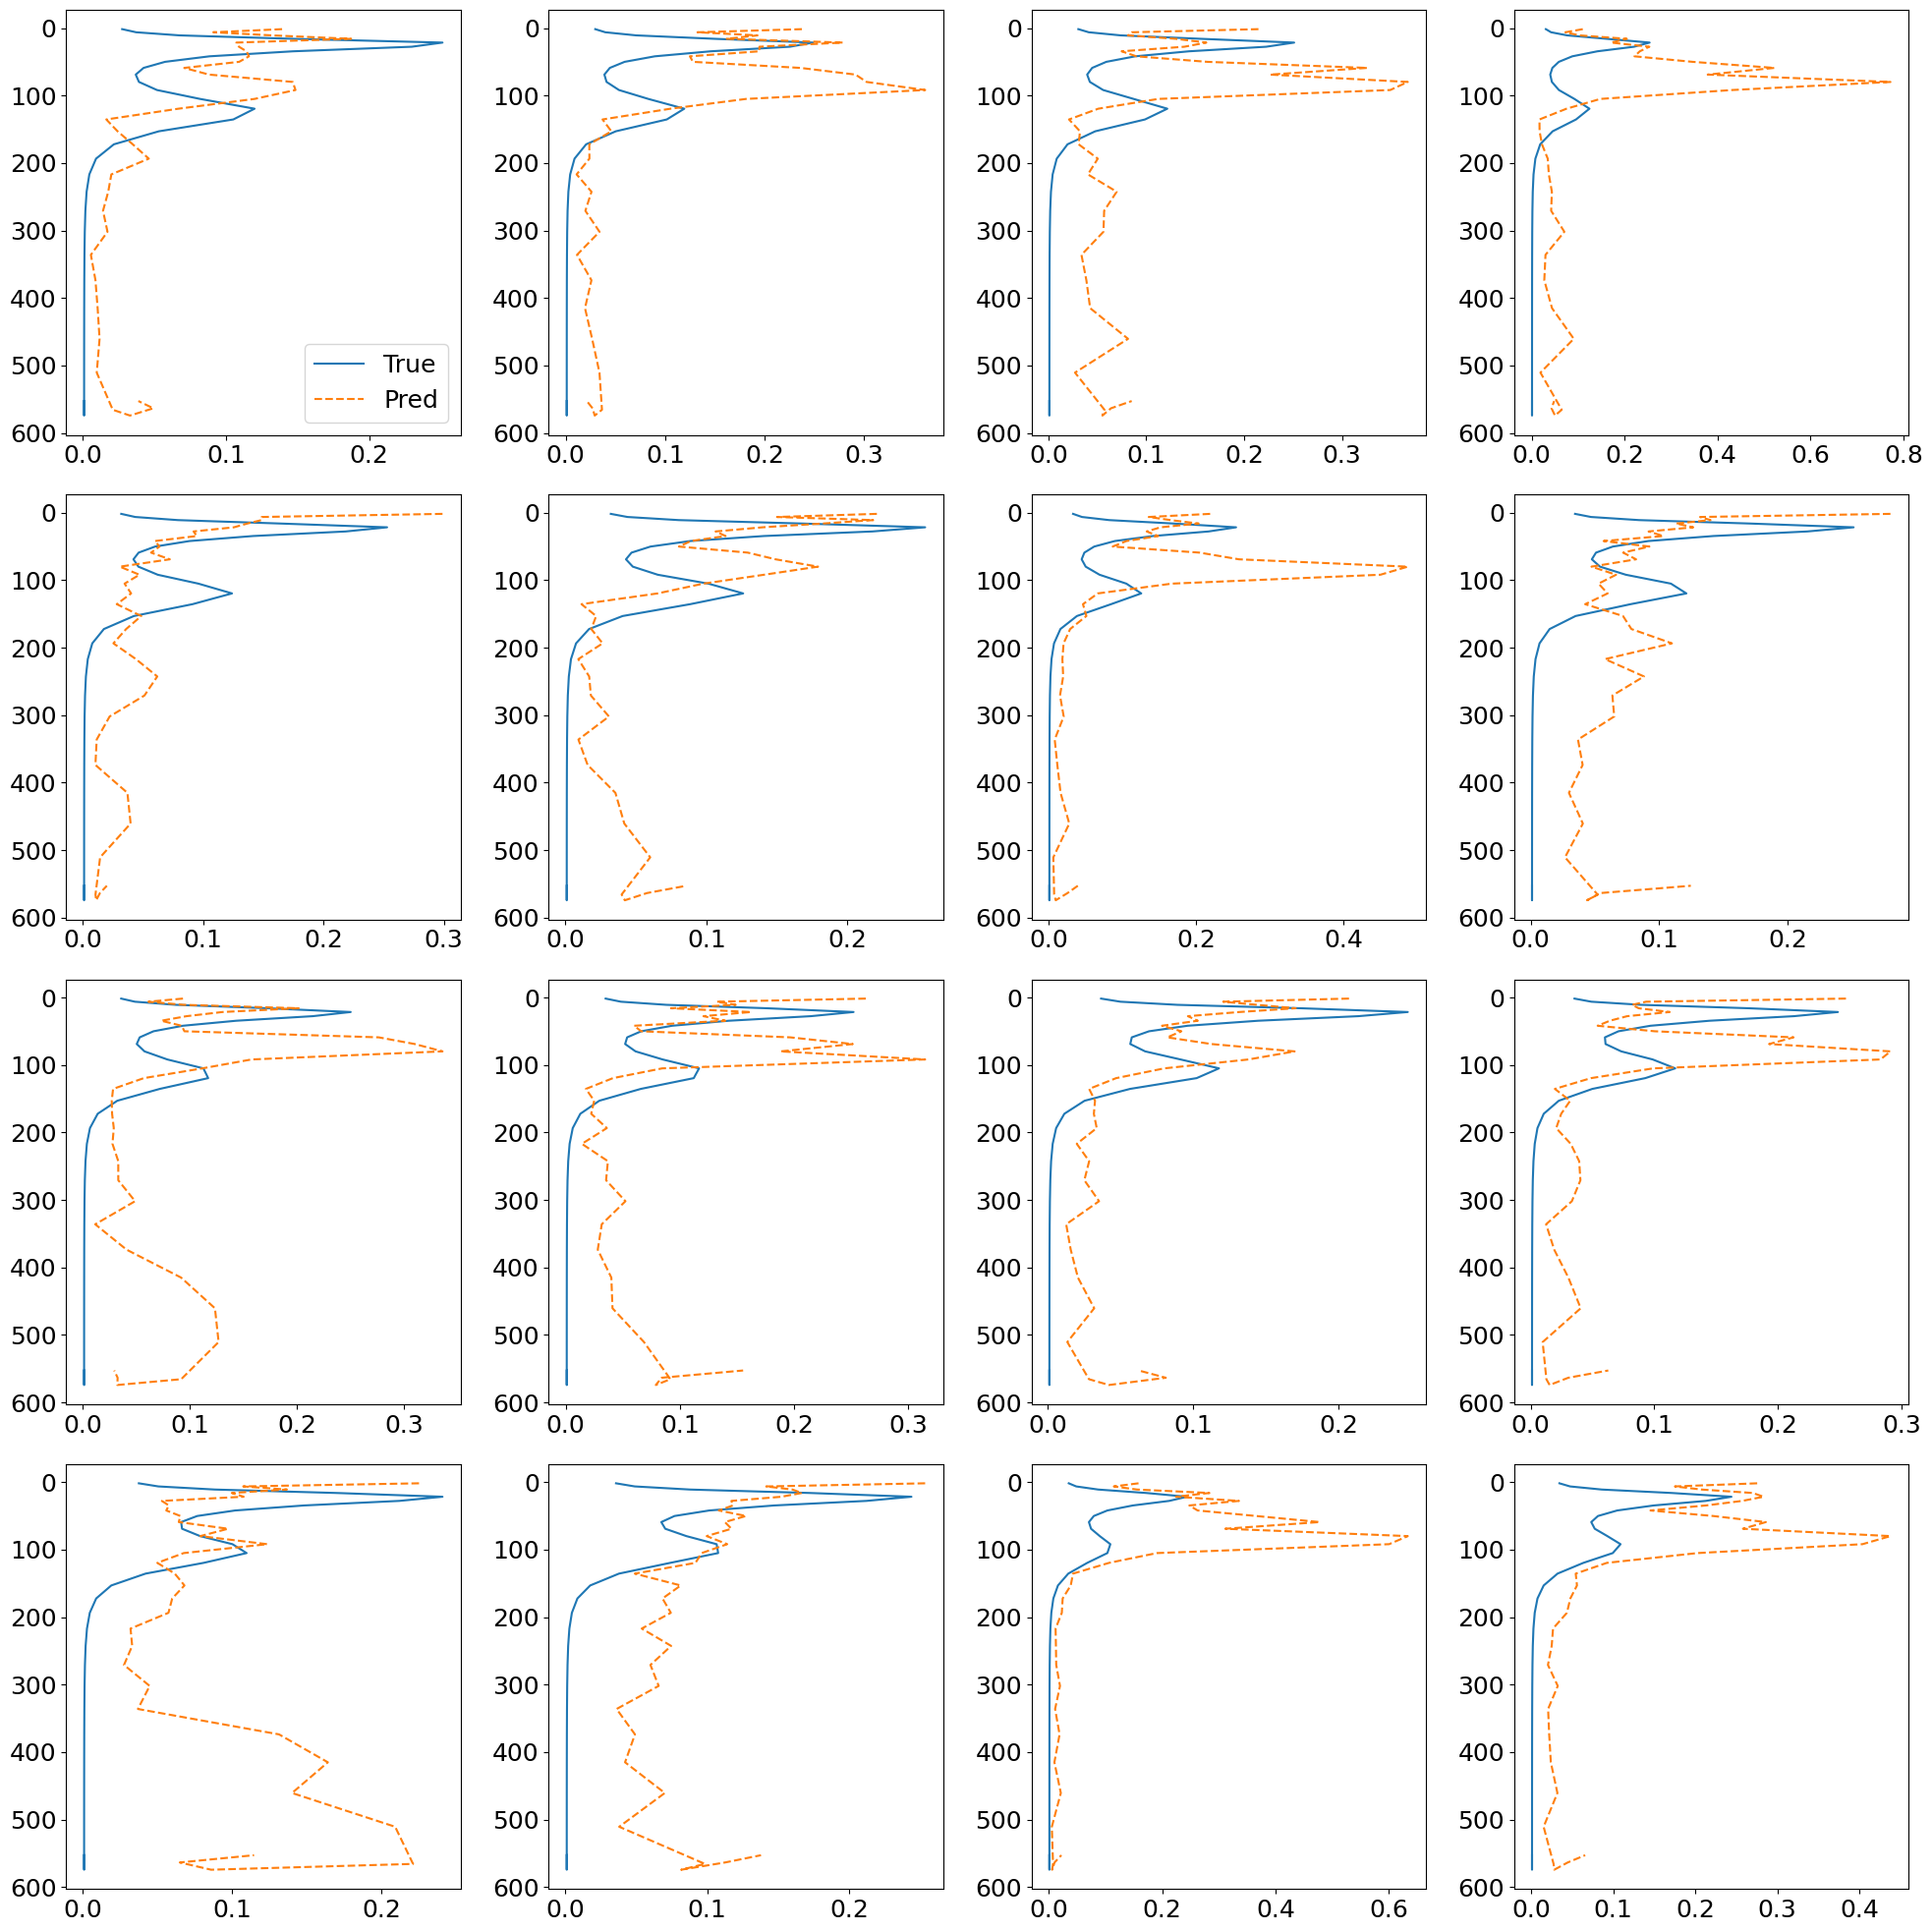

In [67]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.plot(true_logs[i], plot_depths, label='True')
    plt.plot(zmd3_logs[i], plot_depths, label='Pred', linestyle='--')
    plt.gca().invert_yaxis()
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

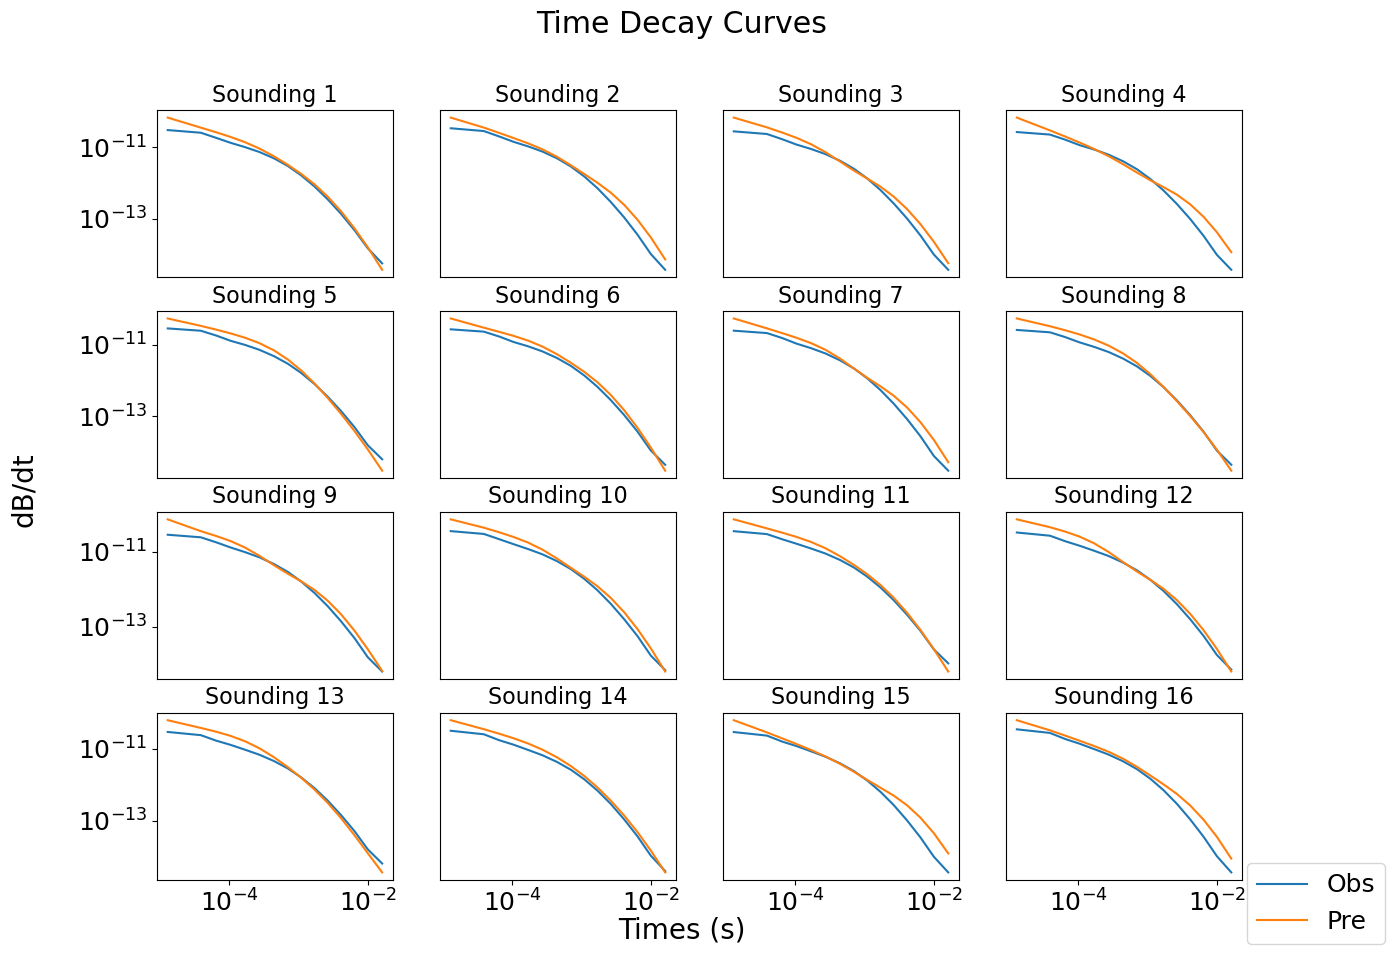

In [68]:
network.plot_data(latent=zmd3)
# Why only one sounding???

d_obs: (16, 16)
d_pre: (16, 16)
data_std: (1, 32, 1)
n_time: 16
d_std: (1, 16)
data tf.Tensor(
[[-8.74061240e-12 -2.08912835e-12 -1.33464008e-12 -6.94634346e-13
  -2.35001634e-13 -6.87156630e-14 -2.64403605e-14 -1.22989760e-14
  -9.09928447e-15 -4.92988803e-15 -6.83338801e-16 -1.90284615e-16
  -1.69843817e-16 -1.08859040e-16 -3.94646785e-16 -5.58443316e-16]
 [-6.36997139e-12 -1.24678469e-12 -7.38930672e-13 -3.86682412e-13
  -1.26213073e-13 -3.97300906e-14 -1.84272272e-14 -1.15516871e-14
  -1.44437837e-14 -1.28870608e-14 -2.72379368e-15 -1.21507946e-15
  -1.97588265e-15 -2.89252434e-15 -1.04005450e-15 -1.46858869e-15]
 [-9.24959415e-12 -2.69399802e-12 -1.55715263e-12 -7.64601598e-13
  -2.12630477e-13 -3.46723925e-14 -8.60405226e-15 -1.61379258e-14
  -2.65769796e-16 -7.48470076e-15 -1.87542624e-15 -8.43650004e-16
  -1.36250935e-15 -2.01596721e-15 -6.13341745e-16 -8.65689854e-16]
 [-9.81254054e-12 -1.56051539e-12 -6.52292294e-13 -2.59257432e-13
  -2.18289352e-14 -2.33595068e-14 -3.1306534

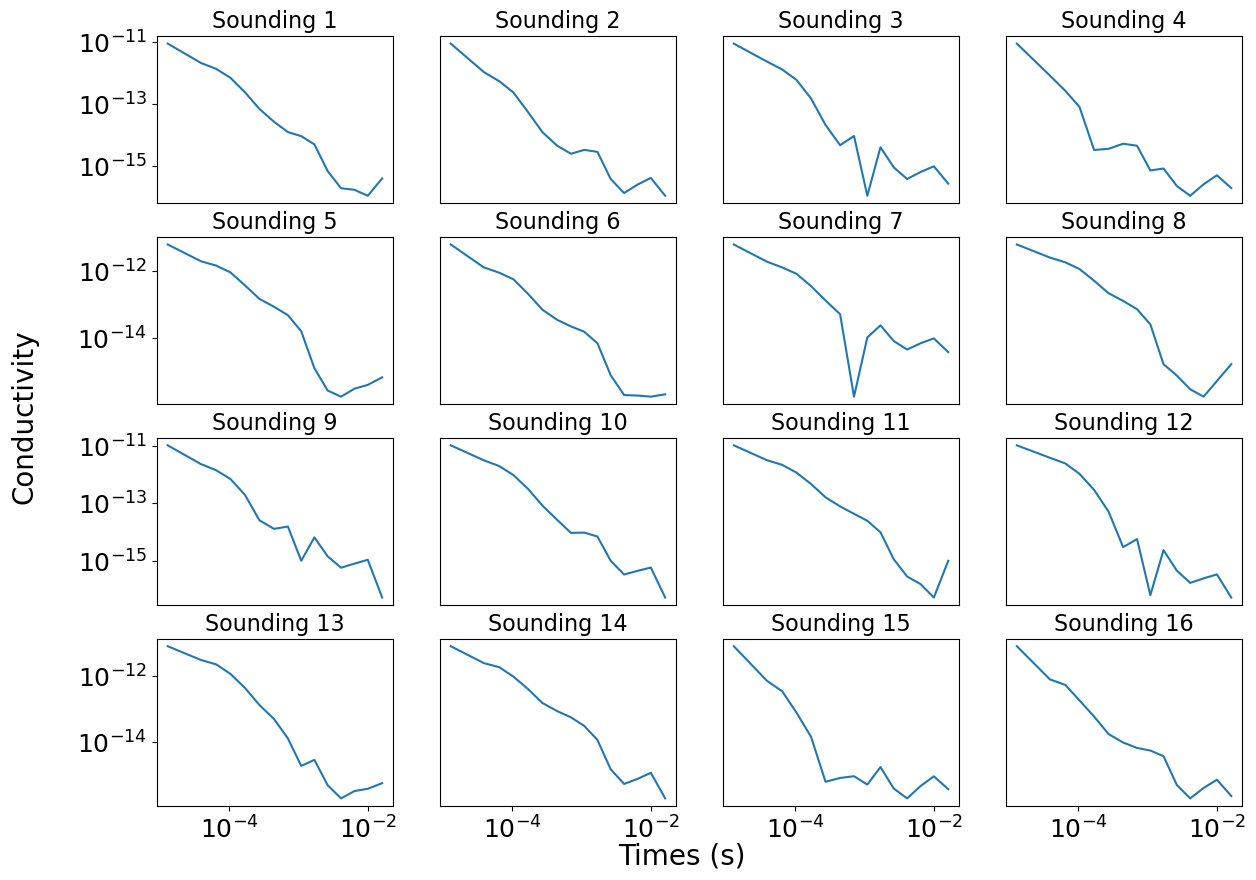

In [69]:
network.plot_residuals(latent=zmd3)